In [2]:
import pandas as pd
import pickle
import re
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import multiprocessing as mp
import wordninja
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.optimize import linear_sum_assignment
import time

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Functions

In [ ]:
from sentence_transformers import SentenceTransformer, util

bert_model = SentenceTransformer('all-mpnet-base-v2')
#bert_model = SentenceTransformer('all-MiniLM-L6-v2')

In [15]:

# Two lists of sentences
sentences1 = ['The cat sits outside',
             'A man is playing guitar',
             'The new movie is awesome']

sentences2 = ['The dog plays in the garden',
              'A woman watches TV',
              'The new movie is so great']

#Compute embedding for both lists
embeddings1 = bert_model.encode(sentences1, convert_to_tensor=True)
embeddings2 = bert_model.encode(sentences2, convert_to_tensor=True)

#Compute cosine-similarits
cosine_scores = util.cos_sim(embeddings1, embeddings2)

#Output the pairs with their score
for i in range(len(sentences1)):
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences1[i], sentences2[i], cosine_scores[i][i]))

The cat sits outside 		 The dog plays in the garden 		 Score: 0.1920
A man is playing guitar 		 A woman watches TV 		 Score: -0.0478
The new movie is awesome 		 The new movie is so great 		 Score: 0.9101


In [37]:
#embeddings1[0]

In [40]:
cosine_scores

tensor([[ 0.2838,  0.1310, -0.0029],
        [ 0.2277, -0.0327, -0.0136],
        [ 0.0543, -0.0502,  0.8939]], device='cuda:0')

In [16]:
# Calculate similarity between two docs with tf-idf vectors by Kuhn-Munkres algorithm.
def match_two_docs(doc1, doc2):
    
    # pairwise distance between sentences
    sim = ((util.cos_sim(doc1, doc2)+1)/2).cpu().numpy()
    #print(sim.shape, min(sim.shape))
    
    # assignment is to minimize the distance of matched sentences
    # WMD may be used here (to do)
    row_ind, col_ind = linear_sum_assignment(1-sim)
    #print(row_ind)
    #print(col_ind)
    
    # total similarity of matched sentences
    score = sim[row_ind, col_ind].sum()
    #print(doc_sim)
    
    # normalize by min. size of two docs
    score1 = score/min(sim.shape)
    
    # normalize by max. size of two docs
    score2 = score/max(sim.shape)
    
    score = [score1, score2]
    
    return score, row_ind, col_ind, sim


In [17]:
def compute_sim(cik, df, bert_model, window = 1): 
    
    result = []
      
    years = np.sort(df.fyear.unique())
    
    for i in range(len(years)-1):
        for j in range(i+1,len(years)):
            if years[j]-years[i] <= window:
                
                doc1 = df[df.fyear == years[i]].text.tolist()
                doc2 = df[df.fyear == years[j]].text.tolist()
                
                doc1 = bert_model.encode(doc1, convert_to_tensor=True)
                doc2 = bert_model.encode(doc2, convert_to_tensor=True)
                
                score, row_ind, col_ind, sim = match_two_docs(doc1, doc2)
                
                # get matched pair similarity
                matched_sim = sim[row_ind, col_ind]
                
                # return CIK, year 1, year 2, four score, 
                # sizes of doc1 and doc2
                # matched paragraphs of doc1, matched paragraphs of doc2
                # similarity of matched paragraphs
                result.append([cik, years[i], years[j], score, sim.shape, \
                               #doc1_idx, doc2_idx, \
                               row_ind, col_ind, matched_sim])
    
    return result

In [18]:
def get_df_for_cik(cik):
    
    df = pd.concat({k: pd.Series(v) for k, v in para_map[cik].items()})
    df = df.reset_index()
    
    df.columns = ['fyear','pid','text']
    df = df.sort_values(by=['fyear','pid'])
    df = df.reset_index(drop = True)
    
    return df

# Test Functions

In [19]:
para_map = pickle.load(open("data/mda/paragraphs_1994_2016.pkl", 'rb'))
#para_map = pickle.load(open("data/mda/paragraphs_1994_2016_original.pkl", 'rb'))
len(para_map)

20893

In [20]:
# get all paragraphs to fit a single dtm. save the index map

para_id_map = {}
cnt = 0
docs = []

cnt = 0

for cik in para_map:
    
    para_id_map[cik] = {}
    
    for fyear in para_map[cik]:
        
        para_id_map[cik][fyear] = [cnt, cnt + len(para_map[cik][fyear])]
        docs += para_map[cik][fyear]
            
        cnt += len(para_map[cik][fyear])

In [21]:
# check one

len(docs)
cnt
len(para_map[20][2000])
para_id_map[20][2000]

9056901

9056901

34

[106, 140]

## Test case 1

In [64]:
# for debug purpose

cik = 1007021

df = get_df_for_cik(cik)
df.head()
df.groupby("fyear")["pid"].count()

,fyear,pid,text
0,1996,0,The following discussion and analysis of the f...
1,1996,1,The Company does not provide forecasts of the ...
2,1996,2,The software industry is highly competitive an...
3,1996,3,Revenue. The Company's revenue consists of lic...
4,1996,4,International revenue decreased dd% to $dd in ...


fyear
1996    26
1997    28
1998    36
1999    35
2000    37
2001    37
Name: pid, dtype: int64

In [65]:
df.fyear.unique()

sim = compute_sim(cik, df, bert_model, window = 1)
sim

array([1996, 1997, 1998, 1999, 2000, 2001])

[[1007021,
  1996,
  1997,
  [0.9614706773024339, 0.8927942003522601],
  (26, 28),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25]),
  array([ 0, 25, 26, 11, 12, 13, 14,  4,  5, 17, 18, 19, 20, 21,  2,  3,  1,
         15, 16,  6,  7,  8,  9, 10, 22, 23]),
  array([1.        , 0.9664059 , 0.89585185, 1.        , 1.        ,
         1.        , 0.99999994, 0.99920285, 0.9932897 , 0.99991393,
         0.9995846 , 0.99906737, 1.0000001 , 0.99748605, 0.9047919 ,
         0.953261  , 0.7643708 , 0.9609228 , 0.94390476, 0.96185416,
         0.95012134, 0.9539539 , 0.91725165, 0.88297653, 0.9626653 ,
         0.99136007], dtype=float32)],
 [1007021,
  1997,
  1998,
  [0.9525763647896903, 0.7408927281697592],
  (28, 36),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
  array([ 0,  2, 27, 13,  4,  5,  6, 17, 18, 19, 20,  1, 11, 12,  3, 1

## Test case 2

In [66]:
# Try with one pair with overall dtm
cik = 1750
df = get_df_for_cik(cik)
df.head()
df.groupby("fyear")["pid"].count()


,fyear,pid,text
0,1994,0,The Company reports its activities in one busi...
1,1994,1,The comparison of net sales of the Company ove...
2,1994,2,Aerospace/aviation manufacturers and certain d...
3,1994,3,The difficult general economic conditions duri...
4,1994,4,The Company believes that its established mark...


fyear
1994     23
1995     23
1996     25
1997     28
1998     28
1999     25
2000     36
2001     44
2002     55
2003     50
2004     49
2005    175
2006     59
2007     60
2008     67
2009     65
2010     57
2011     76
2012     61
2013     75
2014     88
2015     89
2016     85
Name: pid, dtype: int64

In [67]:
sim = compute_sim(cik, df,bert_model, window = 1)
#sim


## Display match

In [22]:
cik = 1007021

df = get_df_for_cik(cik)
df.fyear.unique()

#doc1_idx = df[df.fyear == 1996].index.tolist()
#doc2_idx= df[df.fyear == 1997].index.tolist()

#doc1 = df[df.fyear == 1996].text.tolist()
#doc2 = df[df.fyear == 1997].text.tolist()

doc1_idx = df[df.fyear == 2000].index.tolist()
doc2_idx= df[df.fyear == 2001].index.tolist()

doc1 = df[df.fyear == 2000].text.tolist()
doc2 = df[df.fyear == 2001].text.tolist()

doc1 = bert_model.encode(doc1, convert_to_tensor=True)
doc2 = bert_model.encode(doc2, convert_to_tensor=True)

array([1996, 1997, 1998, 1999, 2000, 2001])

In [69]:
df[df.fyear.isin([1996,1997])]

,fyear,pid,text
0,1996,0,The following discussion and analysis of the f...
1,1996,1,The Company does not provide forecasts of the ...
2,1996,2,The software industry is highly competitive an...
3,1996,3,Revenue. The Company's revenue consists of lic...
4,1996,4,International revenue decreased dd% to $dd in ...
5,1996,5,Software license revenue decreased dd% in fisc...
6,1996,6,Maintenance and services revenue increased dd%...
7,1996,7,Cost of Revenue and Gross Profit. The Company'...
8,1996,8,Cost of maintenance and services revenue consi...
9,1996,9,Selling and Marketing. Selling and marketing e...


In [23]:
score, row_index, col_index, sim = match_two_docs(doc1, doc2)
score

[0.9131855320286106, 0.9131855320286106]

In [24]:
row_index
col_index
#sim

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

array([ 0, 10, 11, 12, 13, 14, 15, 16, 17, 28, 19,  1,  2,  3,  4,  5,  6,
        7,  8, 18, 31, 26, 23, 29, 25, 27,  9, 20, 21, 22, 24, 32, 33, 30,
       34, 35, 36])

In [25]:
for i, row_id in enumerate(row_index):
    print(row_id+1, "("+str(doc1_idx[row_id])+")", "\t",
          col_index[i]+1,"("+str(doc2_idx[col_index[i]])+")",\
          "\t", '%.2f'%sim[row_id, col_index[i]], "\t",\
         # doc1_len[row_id], "\t",\
         # doc2_len[col_index[i]]
         )
    print("-------------")
    print(row_id,df.loc[doc1_idx[row_id]].text)
    print("-------------")
    print(col_index[i], df.iloc[doc2_idx[col_index[i]]].text)
    print("\n")
    

1 (125) 	 1 (162) 	 1.00 	
-------------
0 The following discussion and analysis of the financial condition and results of operations of the Company should be read in conjunction with the financial statements and related notes thereto.
-------------
0 The following discussion and analysis of the financial condition and results of operations of the Company should be read in conjunction with the financial statements and related notes thereto.


2 (126) 	 11 (172) 	 1.00 	
-------------
1 Revenue. The Company's revenue consists of license fees for its WTC ProductCenter and WTC OpCenter software products and fees for professional services and software maintenance. The Company had total revenue of $dd in fiscal dd as compared to total revenue of $dd in fiscal dd, a decrease of $dd or dd%.
-------------
10 Revenue. The Company's revenue consists of license fees for its WTC ProductCenter and WTC OpCenter software products and fees for professional services and software maintenance. The Compan

In [38]:


for i, row_id in enumerate(row_index):
    print(row_id, "("+str(doc1_idx[row_id])+")", "\t",
          col_index[i],"("+str(doc2_idx[col_index[i]])+")",\
          "\t", '%.2f'%sim[row_id, col_index[i]], "\t",\
          doc1_len[row_id], "\t",\
          doc2_len[col_index[i]])
    print("-------------")
    print(row_id,df.loc[doc1_idx[row_id]].text)
    print("-------------")
    print(col_index[i], df.iloc[doc2_idx[col_index[i]]].text)
    print("\n")
    

0 (0) 	 0 (26) 	 1.00 	 14 	 14
-------------
0 The following discussion and analysis of the financial condition and results of operations of the Company should be read in conjunction with the financial statements and related notes thereto.
-------------
0 The following discussion and analysis of the financial condition and results of operations of the Company should be read in conjunction with the financial statements and related notes thereto.


1 (1) 	 25 (51) 	 0.95 	 45 	 50
-------------
1 The Company does not provide forecasts of the future financial performance of the Company. However, from time to time information provided by the Company or statements made by its employees may contain "forward looking" information that involves risks and uncertainties. In particular, statements contained in this Form dd-K which are not historical facts constitute forward looking statements and are made under the safe harbor provisions of the Private Securities Litigation Reform Act of dd. The 

In [96]:
mda_status = pd.read_csv("data/mda/disclosure_mda_status.csv")
mda_status.head()

,cik_orig,name_orig,form_orig,filing_date_orig,text_file,html_file,sic_orig,industry_orig,file_path,num_para,...,f_filing_date,f_name,f_sic,f_cik,h_filing_date,h_report_period,cik,report_period,filing_date,fyear
0,20,K TRON INTERNATIONAL INC,10-K,1996-03-28,edgar/data/20/0000893220-96-000500.txt,edgar/data/20/0000893220-96-000500-index.html,3823.0,Durable Manufacturers,20/0000893220-96-000500.txt,41.0,...,1996-03-28,K TRON INTERNATIONAL INC,"INDUSTRIAL INSTRUMENTS FOR MEASUREMENT, DISPLA...",20.0,1996-03-28,1995-12-31,20,1995-12-31,1996-03-28,1995
1,20,K TRON INTERNATIONAL INC,10-K,1997-03-19,edgar/data/20/0000893220-97-000572.txt,edgar/data/20/0000893220-97-000572-index.html,3823.0,Durable Manufacturers,20/0000893220-97-000572.txt,31.0,...,1997-03-19,K TRON INTERNATIONAL INC,"INDUSTRIAL INSTRUMENTS FOR MEASUREMENT, DISPLA...",20.0,1997-03-19,1996-12-28,20,1996-12-28,1997-03-19,1996
2,20,K TRON INTERNATIONAL INC,10-K405,1998-03-18,edgar/data/20/0000893220-98-000560.txt,edgar/data/20/0000893220-98-000560-index.html,3823.0,Durable Manufacturers,20/0000893220-98-000560.txt,34.0,...,1998-03-18,K TRON INTERNATIONAL INC,"INDUSTRIAL INSTRUMENTS FOR MEASUREMENT, DISPLA...",20.0,1998-03-18,1998-01-03,20,1998-01-03,1998-03-18,1997
3,20,K TRON INTERNATIONAL INC,10-K,1999-03-23,edgar/data/20/0000893220-99-000357.txt,edgar/data/20/0000893220-99-000357-index.html,3823.0,Durable Manufacturers,20/0000893220-99-000357.txt,49.0,...,1999-03-23,K TRON INTERNATIONAL INC,"INDUSTRIAL INSTRUMENTS FOR MEASUREMENT, DISPLA...",20.0,1999-03-23,1999-01-02,20,1999-01-02,1999-03-23,1998
4,20,K TRON INTERNATIONAL INC,10-K405,2000-03-30,edgar/data/20/0000893220-00-000394.txt,edgar/data/20/0000893220-00-000394-index.html,3823.0,Durable Manufacturers,20/0000893220-00-000394.txt,40.0,...,2000-03-30,K TRON INTERNATIONAL INC,"INDUSTRIAL INSTRUMENTS FOR MEASUREMENT, DISPLA...",20.0,2000-03-30,2000-01-01,20,2000-01-01,2000-03-30,1999


In [134]:
mda_status[mda_status.cik ==1853]

,cik_orig,name_orig,form_orig,filing_date_orig,text_file,html_file,sic_orig,industry_orig,file_path,num_para,...,f_filing_date,f_name,f_sic,f_cik,h_filing_date,h_report_period,cik,report_period,filing_date,fyear
64,1853,ABERDEEN IDAHO MINING CO,10KSB,2003-03-17,edgar/data/1853/0001052918-03-000043.txt,edgar/data/1853/0001052918-03-000043-index.html,3711.0,Durable Manufacturers,1853/0001052918-03-000043.txt,4.0,...,2003-03-17,ABERDEEN IDAHO MINING CO,"MINING, QUARRYING OF NONMETALLIC MINERALS (NO ...",1853.0,2003-03-17,2002-12-31,1853,2002-12-31,2003-03-17,2002
65,1853,ABERDEEN IDAHO MINING CO,10KSB,2004-02-20,edgar/data/1853/0001052918-04-000065.txt,edgar/data/1853/0001052918-04-000065-index.html,3711.0,Durable Manufacturers,1853/0001052918-04-000065.txt,4.0,...,2004-02-20,ABERDEEN IDAHO MINING CO,"MINING, QUARRYING OF NONMETALLIC MINERALS (NO ...",1853.0,2004-02-20,2003-12-31,1853,2003-12-31,2004-02-20,2003
66,1853,"MotivNation, Inc.",10KSB,2005-05-19,edgar/data/1853/0001077048-05-000297.txt,edgar/data/1853/0001077048-05-000297-index.html,3711.0,Durable Manufacturers,1853/0001077048-05-000297.txt,55.0,...,2005-05-19,"MotivNation, Inc.","MINING, QUARRYING OF NONMETALLIC MINERALS (NO ...",1853.0,2005-05-19,2004-12-31,1853,2004-12-31,2005-05-19,2004
67,1853,"MotivNation, Inc.",10KSB,2006-03-31,edgar/data/1853/0001077048-06-000127.txt,edgar/data/1853/0001077048-06-000127-index.html,3711.0,Durable Manufacturers,1853/0001077048-06-000127.txt,59.0,...,2006-03-31,"MotivNation, Inc.",MOTOR VEHICLES & PASSENGER CAR BODIES [3711],1853.0,2006-03-31,2005-12-31,1853,2005-12-31,2006-03-31,2005
68,1853,"MotivNation, Inc.",10KSB,2007-04-17,edgar/data/1853/0001077048-07-000192.txt,edgar/data/1853/0001077048-07-000192-index.html,3711.0,Durable Manufacturers,1853/0001077048-07-000192.txt,72.0,...,2007-04-17,"MotivNation, Inc.",MOTOR VEHICLES & PASSENGER CAR BODIES [3711],1853.0,2007-04-17,2006-12-31,1853,2006-12-31,2007-04-17,2006
69,1853,"MotivNation, Inc.",10KSB,2008-05-15,edgar/data/1853/0001266068-08-000048.txt,edgar/data/1853/0001266068-08-000048-index.html,3711.0,Durable Manufacturers,1853/0001266068-08-000048.txt,73.0,...,2008-05-15,"MotivNation, Inc.",MOTOR VEHICLES & PASSENGER CAR BODIES [3711],1853.0,2008-05-15,2007-12-31,1853,2007-12-31,2008-05-15,2007
70,1853,"MotivNation, Inc.",10-K,2009-04-13,edgar/data/1853/0001266068-09-000017.txt,edgar/data/1853/0001266068-09-000017-index.html,3711.0,Durable Manufacturers,1853/0001266068-09-000017.txt,29.0,...,2009-04-13,"MotivNation, Inc.",MOTOR VEHICLES & PASSENGER CAR BODIES [3711],1853.0,2009-04-13,2008-12-31,1853,2008-12-31,2009-04-13,2008
71,1853,"MotivNation, Inc.",10-K,2010-05-14,edgar/data/1853/0001266068-10-000020.txt,edgar/data/1853/0001266068-10-000020-index.html,3711.0,Durable Manufacturers,1853/0001266068-10-000020.txt,30.0,...,2010-05-14,"MotivNation, Inc.",MOTOR VEHICLES & PASSENGER CAR BODIES [3711],1853.0,2010-05-14,2009-12-31,1853,2009-12-31,2010-05-14,2009


In [42]:
# Try one pair with firm-specific DTM

cik = 882692
year1 = 1998
year2 = 1999


df_copy = para[(para.cik == cik)][["year","text"]].copy()
df_copy = df_copy.reset_index()
    
docs = df_copy["text"]
dtm = create_dtm(docs)
    
doc1_idx = df_copy[df_copy.year == year1].index.tolist()
doc2_idx = df_copy[df_copy.year == year2].index.tolist()

doc1 = dtm[doc1_idx]
doc2 = dtm[doc2_idx]

print(doc1_idx)
print(doc2_idx)



[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [44]:
score, row_index, col_index, sim = match_two_docs(doc1, doc2)
score

for i, row_id in enumerate(row_index):
    print(row_id, "("+str(doc1_idx[row_id])+")", "\t",
          col_index[i],"("+str(doc2_idx[col_index[i]])+")",\
          "\t", '%.2f'%sim[row_id, col_index[i]])
    print("-------------")
    print(row_id, df_copy.loc[doc1_idx[row_id]].text)
    print("-------------")
    print(col_index[i], df_copy.iloc[doc2_idx[col_index[i]]].text)
    print("\n")
    

[0.5736552472880472,
 0.4897056989044305,
 0.6840647070895525,
 0.6313175489525268]

0 (35) 	 7 (7) 	 0.87
-------------
0 the company 's   revenues   include sales of software and software   licenses net of sales   returns .   cost of   revenues   includes   the   costs   of   manuals ,   software duplication ,   packaging materials , assembly , paper goods , shipping , amortization of software   development costs and royalty fees paid to licensors of third - party software bundled with the company 's products .
-------------
7 cost of revenues includes the costs of manuals , software duplication ,   packaging materials , assembly , paper goods , shipping and royalty fees paid to licensors of third - party software bundled with the company 's products .


1 (36) 	 8 (8) 	 0.80
-------------
1 research and development   expenses consist   primarily of personnel and equipment costs required to conduct the company 's development effort . software development costs are expensed as incurred .
-------------
8 research and development   expenses consist   primarily of person

In [47]:
# Matched but with low sim < 0.3 (may change to lower number )
# or sentence cannot find a match
thresh = 0.3
row_index
col_index

for i, para_id in enumerate(doc1_idx):
    if (i not in row_index):
        print(i, "("+str(doc1_idx[i])+")", "\t", '\t', "\t", '\t','\t')
        print("-------------")
        print(df_copy.loc[para_id].text)
        print("\n")
            
    else:
        match_id = row_index.tolist().index(i)  # id in the matched list
        #print(match_id, row_index[match_id], col_index[match_id])
        if sim[row_index[match_id], col_index[match_id]] < thresh:
        
            print(row_index[match_id], "("+str(doc1_idx[row_index[match_id]])+")","\t", \
                  col_index[match_id], "("+str(doc2_idx[col_index[match_id]])+")", "\t", \
                  '%.2f'%sim[row_index[match_id], col_index[match_id]])
            print("-------------")
            print(row_index[match_id], df_copy.loc[doc1_idx[row_index[match_id]]].text)
            print("-------------")
            print(col_index[match_id], df_copy.iloc[doc2_idx[col_index[match_id]]].text)
            print("\n")

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 32, 33, 34, 36, 38, 39,
       40])

array([ 7,  8,  6,  9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       28, 25, 26, 29, 30, 31,  1, 32, 12,  0,  2, 13, 33, 27,  3,  5,  4,
       34])

3 (38) 	 9 (9) 	 0.27
-------------
3 during dd and dd ,   the   company 's   research and   development ,   marketing and sales efforts were focused upon the   company 's   core   technologies   in sound and music .   the company has continued to reduce its reliance on technology   licensed from others through   internal   development of superior   technologies   or through direct acquisition of desirable technologies .
-------------
9 during dd and dd ,   the   company 's   research   and   development   efforts   were focused upon the company 's   core   technologies   in sound and music .   in dd the company   substantially   increased its expenditures for product development as it began   development   of   recordlab.com   and content for the website .   the company believes that successful   execution of this strategy will result in higher gross margins for its software business .   these development   efforts may not result in timely   introduction   of   new   products ,   and 

# Calculate all firms

In [124]:
# run by cik

threads = 0
finishes = 0
batch = 5

output = []
results = []
pool=mp.Pool(processes=10)
start= time.time()

#para_map = pickle.load(open("data/mda/paragraphs_1994_2016.pkl", 'rb'))
print("total ciks: ", len(para_map))

cnt = 0

for cik in para_map:
    
    df = get_df_for_cik(cik)
    
    args = (cik, df, 1)
    
    threads+=1
        
    results.append(pool.apply_async(compute_sim, args = args))
    
    if threads%batch == 0:
        print("send process {}".format(threads))
        break
    

for p in results: 
    
    o = p.get()
    
    output += o
    
    finishes += 1
    
    if finishes%batch == 0:
        
        print("finish process {} @ {}".format(finishes, time.time()-start))
        
        # save continously
        pickle.dump(output, open("data/metric/paragraph_sim.pkl", "wb"))

pickle.dump(output, open("data/metric/paragraph_sim.pkl", "wb"))

print("\n==========Done !!!!=============")

total ciks:  20893
send process 5
finish process 5 @ 0.2726726531982422

==========Done !!!!=============


In [117]:
output

[[20,
  1995,
  1996,
  [0.7632464241544741,
   0.5770887597265536,
   0.7463789646787461,
   0.5922951884016213],
  (41, 31),
  array([ 0,  1,  3,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
         23, 24, 25, 26, 28, 31, 32, 33, 35, 36, 37, 38, 39, 40]),
  array([ 0,  1, 20,  2, 21,  3,  4,  5,  7,  6,  8,  9, 10, 11, 12, 13, 14,
         15, 16, 18, 19, 17, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
  array([0.93753694, 0.55408075, 0.52002718, 0.65019177, 0.38627732,
         0.73903348, 0.73029   , 0.73333307, 0.98088939, 0.54827539,
         0.69575396, 0.86804056, 0.88165404, 0.96988378, 0.88925919,
         0.79964875, 0.96610245, 1.        , 0.74011862, 0.37596543,
         0.69001437, 0.23973362, 0.89671951, 0.51705479, 0.65394184,
         0.85232794, 0.94650351, 0.99602447, 0.9784387 , 0.94356766,
         0.97995067])],
 [20,
  1996,
  1997,
  [0.8627559120004243,
   0.786630390353328,
   0.8565891488110964,
   0.8267528975603727],
  (31, 34),
  array([ 0,  1,  2, 

# Organize results

In [5]:
results = pickle.load(open("data/metric/paragraph_sim_raw.pkl", "rb"))
len(results)

128369

In [6]:
results[0]

[20,
 1995,
 1996,
 [0.7632464241544741,
  0.5770887597265536,
  0.7463789646787461,
  0.5922951884016213],
 (41, 31),
 array([ 0,  1,  3,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        23, 24, 25, 26, 28, 31, 32, 33, 35, 36, 37, 38, 39, 40]),
 array([ 0,  1, 20,  2, 21,  3,  4,  5,  7,  6,  8,  9, 10, 11, 12, 13, 14,
        15, 16, 18, 19, 17, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 array([0.93753694, 0.55408075, 0.52002718, 0.65019177, 0.38627732,
        0.73903348, 0.73029   , 0.73333307, 0.98088939, 0.54827539,
        0.69575396, 0.86804056, 0.88165404, 0.96988378, 0.88925919,
        0.79964875, 0.96610245, 1.        , 0.74011862, 0.37596543,
        0.69001437, 0.23973362, 0.89671951, 0.51705479, 0.65394184,
        0.85232794, 0.94650351, 0.99602447, 0.9784387 , 0.94356766,
        0.97995067])]

In [6]:
result_map = {}

for r in results:
    cik = r[0]
    y1 = r[1]
    y2 = r[2]
    score = r[3]
    size = r[4]
    match = np.vstack([r[5], r[6], r[7]]).T
    
    entry = {"score": score, "size": size, "match": match}
    
    if cik not in result_map:
        result_map[cik] = {}
        
    result_map[cik][(y1, y2)] = entry
    

In [7]:
pickle.dump(result_map, open("data/metric/paragraph_sim.pkl", "wb"))

In [6]:
#result_map = pickle.load(open("data/change/paragraph_sim.pkl", "rb"))

In [8]:
len(result_map)
result_map[20]

18278

{(1995,
  1996): {'score': [0.7632464241544741,
   0.5770887597265536,
   0.7463789646787461,
   0.5922951884016213], 'size': (41,
   31), 'match': array([[ 0.        ,  0.        ,  0.93753694],
         [ 1.        ,  1.        ,  0.55408075],
         [ 3.        , 20.        ,  0.52002718],
         [ 5.        ,  2.        ,  0.65019177],
         [ 6.        , 21.        ,  0.38627732],
         [ 7.        ,  3.        ,  0.73903348],
         [ 8.        ,  4.        ,  0.73029   ],
         [11.        ,  5.        ,  0.73333307],
         [12.        ,  7.        ,  0.98088939],
         [13.        ,  6.        ,  0.54827539],
         [14.        ,  8.        ,  0.69575396],
         [15.        ,  9.        ,  0.86804056],
         [16.        , 10.        ,  0.88165404],
         [17.        , 11.        ,  0.96988378],
         [18.        , 12.        ,  0.88925919],
         [19.        , 13.        ,  0.79964875],
         [20.        , 14.        ,  0.96610245],
    

In [9]:
len(result_map)
result_map[20][(1995, 1996)]

18278

{'score': [0.7632464241544741,
  0.5770887597265536,
  0.7463789646787461,
  0.5922951884016213],
 'size': (41, 31),
 'match': array([[ 0.        ,  0.        ,  0.93753694],
        [ 1.        ,  1.        ,  0.55408075],
        [ 3.        , 20.        ,  0.52002718],
        [ 5.        ,  2.        ,  0.65019177],
        [ 6.        , 21.        ,  0.38627732],
        [ 7.        ,  3.        ,  0.73903348],
        [ 8.        ,  4.        ,  0.73029   ],
        [11.        ,  5.        ,  0.73333307],
        [12.        ,  7.        ,  0.98088939],
        [13.        ,  6.        ,  0.54827539],
        [14.        ,  8.        ,  0.69575396],
        [15.        ,  9.        ,  0.86804056],
        [16.        , 10.        ,  0.88165404],
        [17.        , 11.        ,  0.96988378],
        [18.        , 12.        ,  0.88925919],
        [19.        , 13.        ,  0.79964875],
        [20.        , 14.        ,  0.96610245],
        [23.        , 15.        ,  1.   

In [13]:
r[5]

array([ 0,  1,  3,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       23, 24, 25, 26, 28, 31, 32, 33, 35, 36, 37, 38, 39, 40])

In [14]:
r[6]

array([ 0,  1, 20,  2, 21,  3,  4,  5,  7,  6,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 18, 19, 17, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [22]:
np.vstack([r[5], r[6]]).T

array([[ 0,  0],
       [ 1,  1],
       [ 3, 20],
       [ 5,  2],
       [ 6, 21],
       [ 7,  3],
       [ 8,  4],
       [11,  5],
       [12,  7],
       [13,  6],
       [14,  8],
       [15,  9],
       [16, 10],
       [17, 11],
       [18, 12],
       [19, 13],
       [20, 14],
       [23, 15],
       [24, 16],
       [25, 18],
       [26, 19],
       [28, 17],
       [31, 22],
       [32, 23],
       [33, 24],
       [35, 25],
       [36, 26],
       [37, 27],
       [38, 28],
       [39, 29],
       [40, 30]])

# Difference between BERT match and TFIDF match

In [2]:
bert_match = pickle.load(open("data/change/paragraph_sim_bert.pkl", "rb"))

tfidf_match = pickle.load(open("data/change/paragraph_sim.pkl", "rb"))

In [4]:
bert_match[20][(1995, 1996)]

{'score': [0.9562679413826235, 0.723031858118569],
 'size': (41, 31),
 'match': array([[ 0.        ,  0.        ,  0.98386681],
        [ 1.        ,  1.        ,  0.95965493],
        [ 5.        ,  2.        ,  0.93160373],
        [ 6.        , 20.        ,  0.86246496],
        [ 7.        ,  3.        ,  0.98884386],
        [ 8.        ,  4.        ,  0.96260548],
        [11.        ,  5.        ,  0.9747777 ],
        [12.        ,  7.        ,  0.99360722],
        [13.        ,  6.        ,  0.9221859 ],
        [14.        ,  8.        ,  0.97504497],
        [15.        ,  9.        ,  0.98967874],
        [16.        , 10.        ,  0.98671734],
        [17.        , 11.        ,  0.98505539],
        [18.        , 12.        ,  0.99050504],
        [19.        , 13.        ,  0.94404954],
        [20.        , 14.        ,  0.98394495],
        [23.        , 15.        ,  1.        ],
        [24.        , 16.        ,  0.95593768],
        [25.        , 18.        ,  0.8

In [21]:
match_pairs = pd.DataFrame([], columns =["cik","y1","y2","p1","p2","sim_bert","sim_tfidf"])
cnt = 0

for cik in bert_match:
    
    for (y1, y2) in bert_match[cik]:
        #print(y1, y2)
        df1 = pd.DataFrame(bert_match[cik][(y1, y2)]["match"], \
                          columns = ["p1","p2","sim_bert"])
        
        df2 = pd.DataFrame(tfidf_match[cik][(y1, y2)]["match"], \
                          columns = ["p1","p2","sim_tfidf"])
        
        df = df1.merge(df2, on=["p1","p2"], how="outer")
        
        df["cik"] = cik
        df["y1"] = y1
        df["y2"] = y2
        
        match_pairs = match_pairs.append(df, ignore_index=True)
    #break
    
    cnt += 1
    if cnt%500 == 0:
        print(cnt)
        #break
        

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000


In [27]:
len(match_pairs)

8857244

In [22]:
match_pairs.to_pickle("data/change/bert_tfidf_match.pkl")

In [36]:
match_pairs['match'] = match_pairs.apply(lambda row: 'TF-IDF' if pd.isnull(row["sim_bert"])\
                                                         else 'BERT' if pd.isnull(row["sim_tfidf"]) \
                                                                  else 'BOTH', \
                                         axis =1)

match_pairs.to_pickle("data/change/bert_tfidf_match.pkl")                                         

In [25]:
match_pairs = pd.read_pickle("data/change/bert_tfidf_match.pkl")

In [27]:
match_pairs["sim_bert_orig"] = match_pairs["sim_bert"]*2 -1

In [28]:
match_pairs[105:120]

,cik,y1,y2,p1,p2,sim_bert,sim_tfidf,match,sim_bert_orig
105,1143548,2004,2005,26.0,10.0,0.730580,NaN,BERT,0.461161
106,1143548,2004,2005,27.0,8.0,0.767919,NaN,BERT,0.535837
107,1143548,2004,2005,0.0,10.0,NaN,0.019265,TF-IDF,NaN
108,1143548,2004,2005,6.0,7.0,NaN,0.159595,TF-IDF,NaN
109,1143548,2004,2005,7.0,8.0,NaN,0.032947,TF-IDF,NaN
110,1143548,2004,2005,8.0,5.0,NaN,0.308941,TF-IDF,NaN
111,1143548,2004,2005,10.0,9.0,NaN,0.014089,TF-IDF,NaN
112,1143548,2004,2005,13.0,0.0,NaN,0.044257,TF-IDF,NaN
113,1143548,2004,2005,15.0,2.0,NaN,0.088997,TF-IDF,NaN
114,1143548,2004,2005,19.0,1.0,NaN,0.159775,TF-IDF,NaN


In [29]:
match_pairs["match"].value_counts()

BOTH      5352778
BERT      1752233
TF-IDF    1752233
Name: match, dtype: int64

In [30]:
plt.rcParams['figure.dpi'] = 300
sns.set_style("white")
sns.set_context("paper")

[Text(0.5, 1.0, 'Paragraph Match by BERT')]

[Text(0.5, 0, 'Matched Paragraph Similarity')]

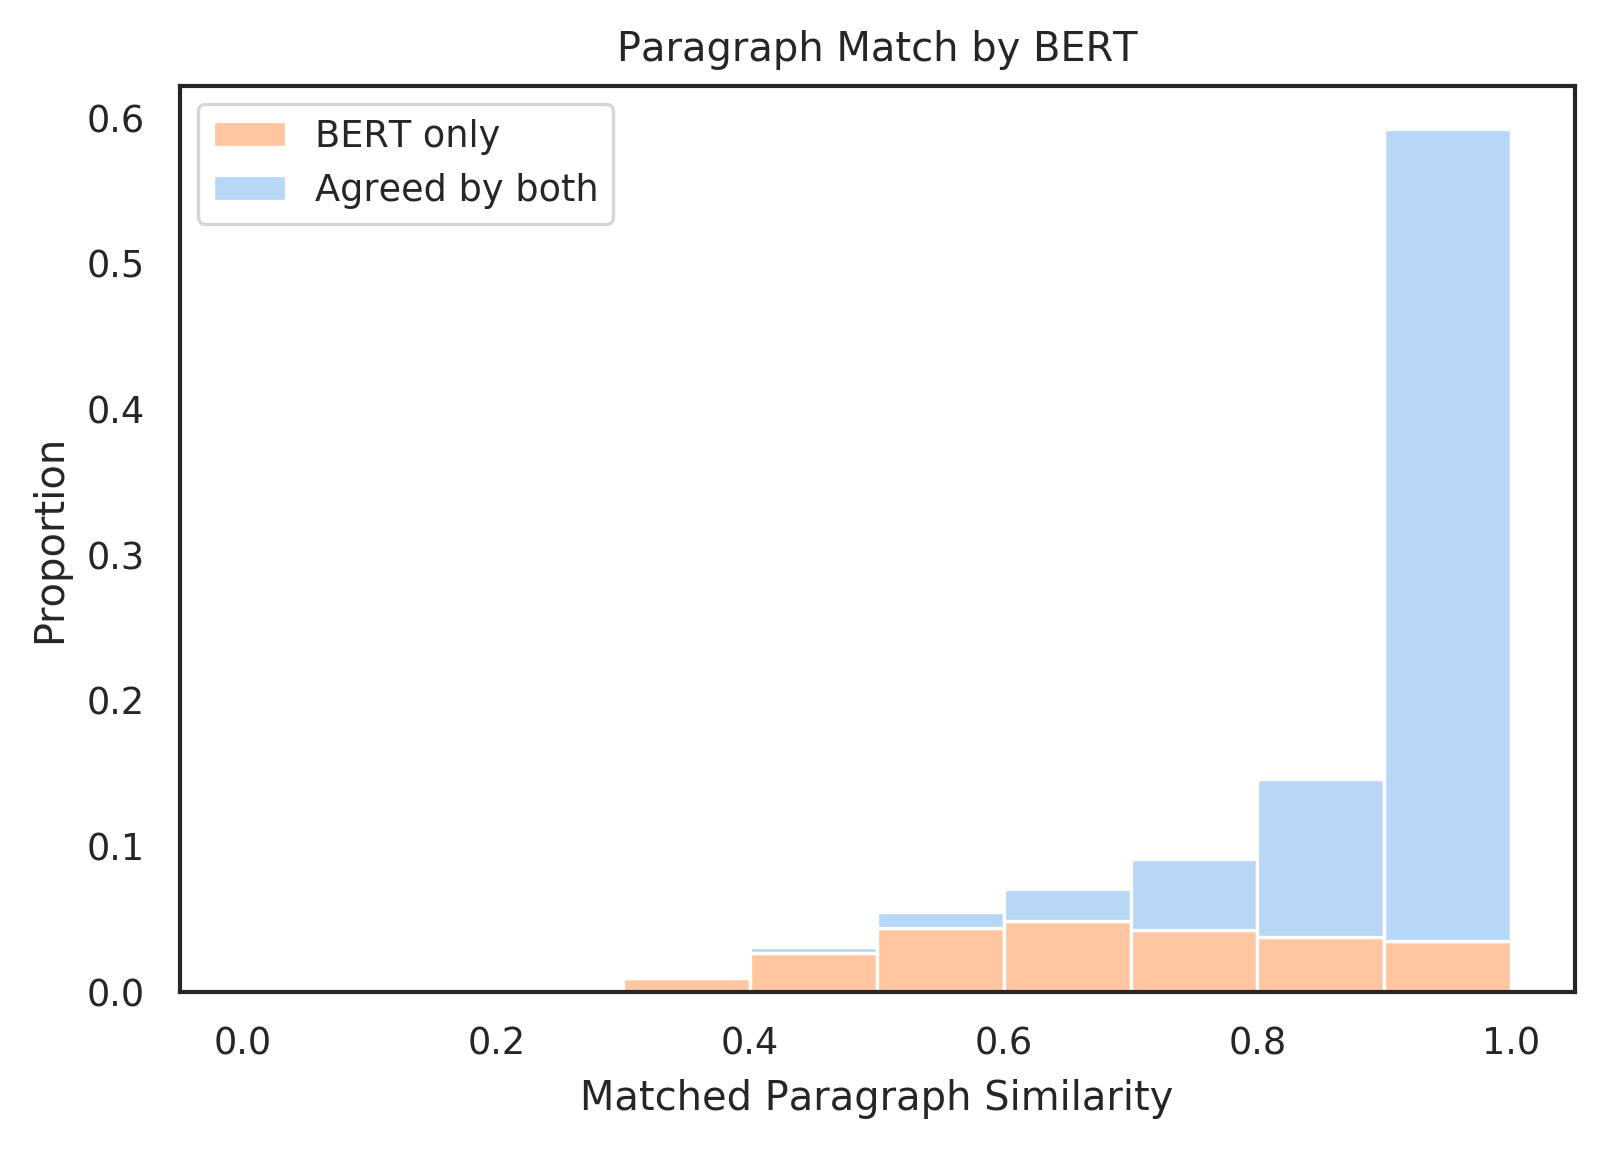

In [31]:
g = sns.histplot(data = match_pairs[~pd.isnull(match_pairs.sim_bert)], x = "sim_bert_orig", stat="proportion", multiple="stack",
             kde=False, palette="pastel", hue="match",bins=np.arange(0, 1.1, 0.1),
             element="bars", legend=True)
g.set(title='Paragraph Match by BERT')
g.set(xlabel='Matched Paragraph Similarity')
plt.legend(title=None, labels=[ 'BERT only','Agreed by both'])
plt.show()

[Text(0.5, 1.0, 'Paragraph Match by BERT')]

[Text(0.5, 0, 'Matched Paragraph Similarity')]

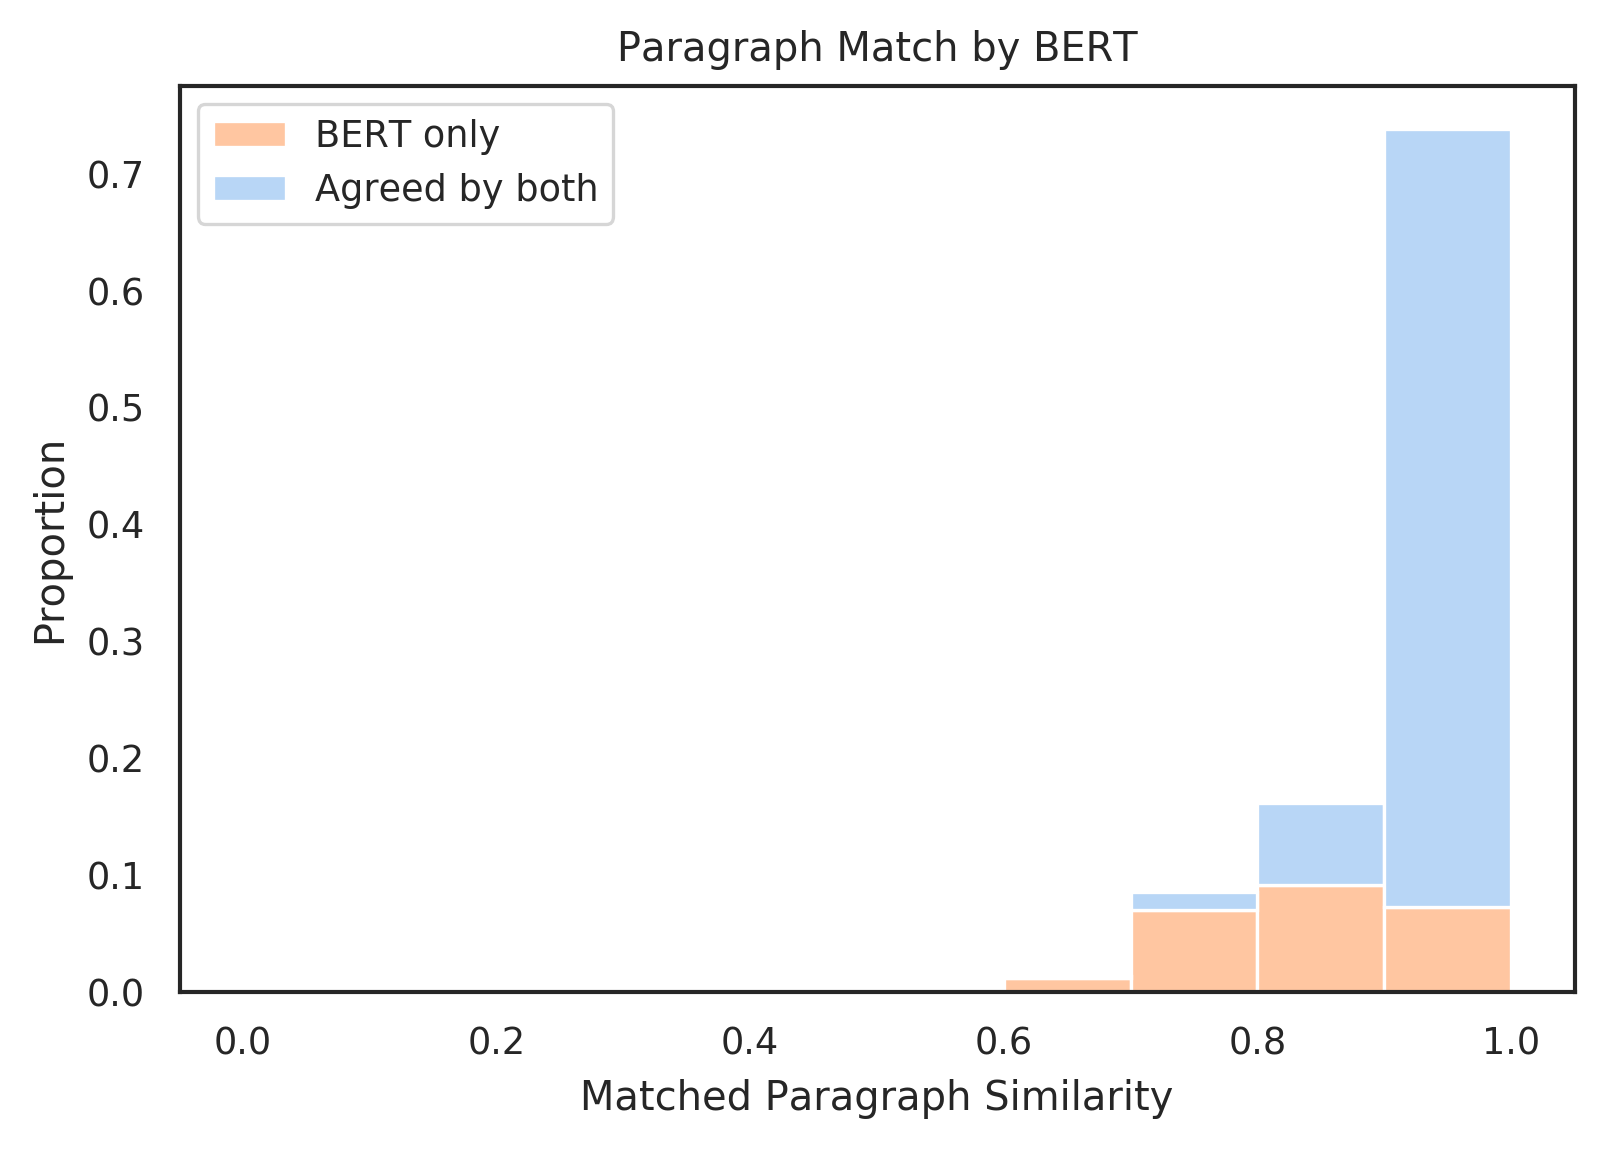

In [6]:
g = sns.histplot(data = match_pairs[~pd.isnull(match_pairs.sim_bert)], x = "sim_bert", stat="proportion", multiple="stack",
             kde=False, palette="pastel", hue="match",bins=np.arange(0, 1.1, 0.1),
             element="bars", legend=True)
g.set(title='Paragraph Match by BERT')
g.set(xlabel='Matched Paragraph Similarity')
plt.legend(title=None, labels=[ 'BERT only','Agreed by both'])
plt.show()

[Text(0.5, 1.0, 'Paragraph Match by TF-IDF')]

[Text(0.5, 0, 'Matched Paragraph Similarity')]

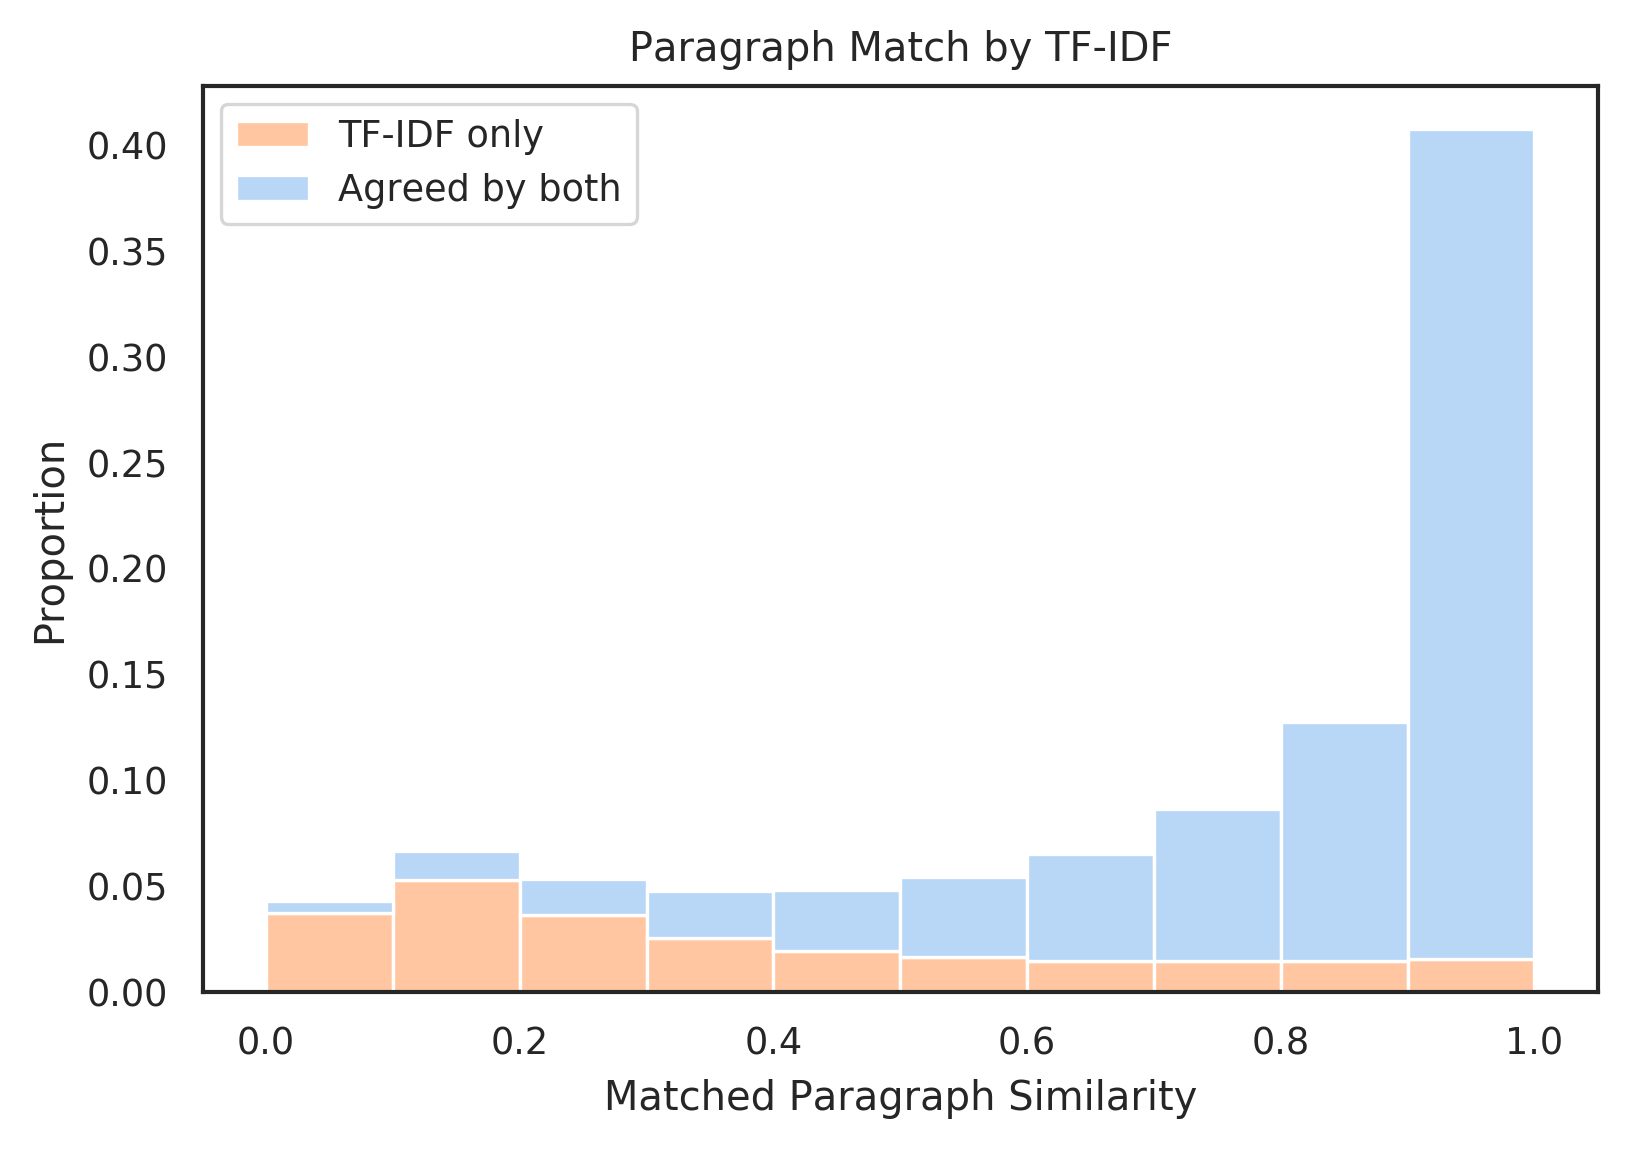

In [9]:
g = sns.histplot(data = match_pairs[~pd.isnull(match_pairs.sim_tfidf)], x = "sim_tfidf", stat="proportion", multiple="stack",
             kde=False, palette="pastel", hue="match",bins=np.arange(0, 1.1, 0.1),
             element="bars", legend=True)
g.set(title='Paragraph Match by TF-IDF')
g.set(xlabel='Matched Paragraph Similarity')
plt.legend(title=None, labels=[ 'TF-IDF only','Agreed by both'])
plt.show()

In [34]:
m = match_pairs[(match_pairs.sim_bert_orig>=0.7) | (match_pairs.sim_tfidf>=0.3)]
len(m)
m["match"].value_counts()

6881435

BOTH      5194930
TF-IDF     866620
BERT       819885
Name: match, dtype: int64

In [35]:
5194930/6881435

0.7549195770940218

# Tokenize and clean up paragraph text

In [18]:
para_map = pickle.load(open("data/mda/paragraphs_1994_2016.pkl", 'rb'))
len(para_map)

20893

In [19]:
vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+'[vnt]\w*\b|\b\w\w+\b")
tokenizer = vectorizer.build_tokenizer()

In [ ]:
def tokenize_paragraph(cik, para_per_cik):
    
    for fyear in para_per_cik:
        
        for i, p in enumerate(para_per_cik[fyear]):
            
            tokens = tokenizer(p)
            cleaned_tokens = []
            
            for w in tokens:  # detect if long tokens are words concatenated
                if len(w)>=10:
                    cleaned_tokens += wordninja.split(w)
                else:
                    cleaned_tokens.append(w)
            
            para_per_cik[fyear][i] = cleaned_tokens 
            
    return (cik, para_per_cik)

In [ ]:
# run by cik

threads = 0
finishes = 0
batch = 5

#output = {}
results = []
pool=mp.Pool(processes=10)
start= time.time()

#para_map = pickle.load(open("data/mda/paragraphs_1994_2016.pkl", 'rb'))
print("total ciks: ", len(para_map))

cnt = 0

for cik in para_map:
    
    para_per_cik = para_map[cik]
    
    threads+=1
        
    results.append(pool.apply_async(tokenize_paragraph, args = (cik, para_per_cik))
    
    if threads%batch == 0:
        print("send process {}".format(threads))
        break
    

for p in results: 
    
    cik, out = p.get()
    
    para_map[cik] = out
    
    finishes += 1
    
    if finishes%batch == 0:
        
        print("finish process {} @ {}".format(finishes, time.time()-start))
        
        # save continously
        #pickle.dump(output, open("data/metric/paragraph_sim.pkl", "wb"))

pickle.dump(para_map, open("data/mda/paragraph_1994_2016_tokenized.pkl", "wb"))

print("\n==========Done !!!!=============")

In [ ]:
cnt = 0
start = time.time()


for cik in para_map:
    
    for fyear in para_map[cik]:
        
        for i, p in enumerate(para_map[cik][fyear]):
            
            tokens = tokenizer(p)
            cleaned_tokens = []
            
            for w in tokens:  # detect if long tokens are words concatenated
                if len(w)>=10:
                    cleaned_tokens += wordninja.split(w)
                else:
                    cleaned_tokens.append(w)
            
            para_map[cik][fyear][i] = cleaned_tokens 
            
    cnt +=1
    if cnt%100 == 0:
        print("{0} in {1:.2f}".format(cnt, time.time()-start))
        
    #break

100 in 44.95
200 in 90.14
300 in 138.05
400 in 181.83
500 in 234.10
600 in 269.75
700 in 312.43
800 in 357.37
900 in 402.38
1000 in 442.00
1100 in 489.13
1200 in 533.83
1300 in 560.45
1400 in 591.92
1500 in 633.12
1600 in 676.68
1700 in 718.98
1800 in 755.44
1900 in 783.16
2000 in 819.35
2100 in 858.67
2200 in 887.31
2300 in 921.46
2400 in 959.06
2500 in 1002.05
2600 in 1028.67
2700 in 1058.65
2800 in 1086.27
2900 in 1111.81
3000 in 1141.03
3100 in 1166.85
3200 in 1190.46
3300 in 1219.45
3400 in 1243.65
3500 in 1279.32
3600 in 1310.75
3700 in 1345.34
3800 in 1374.34
3900 in 1400.65
4000 in 1428.96
4100 in 1453.54
4200 in 1486.08
4300 in 1518.11
4400 in 1542.23
4500 in 1569.35
4600 in 1594.66
4700 in 1628.74
4800 in 1655.96
4900 in 1680.48
5000 in 1702.00
5100 in 1737.00
5200 in 1763.70
5300 in 1795.63
5400 in 1827.53
5500 in 1868.48
5600 in 1895.67
5700 in 1927.73
5800 in 1960.62
5900 in 1996.18
6000 in 2030.93
6100 in 2064.61
6200 in 2113.59
6300 in 2141.97
6400 in 2177.11
6500 in 221

In [3]:
#pickle.dump(para_map, open("data/mda/paragraph_1994_2016_tokenized.pkl", "wb"))

para_map = pickle.load(open("data/mda/paragraph_1994_2016_tokenized.pkl", "rb"))

In [5]:
for cik in para_map:
    for y in para_map[cik]:
        for p in para_map[cik][y]:
            print(p)
            break
        break

['In', 'dd', 'the', 'Company', 'reported', 'pre', 'tax', 'loss', 'of', 'dd', 'The', 'principal', 'components', 'of', 'this', 'loss', 'were', 'second', 'quarter', 'loss', 'of', 'dd', 'recorded', 'in', 'connection', 'with', 'the', 'sale', 'of', 'Color', 'tronic', 'GmbH', 'Color', 'tronic', 'German', 'subsidiary', 'and', 'related', 'patent', 'and', 'patent', 'applications', 'and', 'third', 'and', 'fourth', 'quarter', 'losses', 'totaling', 'dd', 'resulting', 'from', 'the', 'sale', 'of', 'the', 'Company', 'Brazilian', 'and', 'Hasler', 'France', 'businesses', 'On', 'pro', 'forma', 'basis', 'assuming', 'that', 'these', 'transactions', 'and', 'the', 'discontinuance', 'of', 'the', 'Company', 'other', 'Color', 'tronic', 'brand', 'business', 'had', 'occurred', 'at', 'the', 'beginning', 'of', 'the', 'dd', 'fiscal', 'year', 'the', 'Company', 'had', 'dd', 'pre', 'tax', 'income', 'of', 'dd', 'and', 'net', 'income', 'of', 'dd']
['The', 'Company', 'reports', 'its', 'activities', 'in', 'one', 'business'

In [14]:
''.join(p)

'InddtheCompanyreportedpretaxlossofddTheprincipalcomponentsofthislossweresecondquarterlossofddrecordedinconnectionwiththesaleofColortronicGmbHColortronicGermansubsidiaryandrelatedpatentandpatentapplicationsandthirdandfourthquarterlossestotalingddresultingfromthesaleoftheCompanyBrazilianandHaslerFrancebusinessesOnproformabasisassumingthatthesetransactionsandthediscontinuanceoftheCompanyotherColortronicbrandbusinesshadoccurredatthebeginningoftheddfiscalyeartheCompanyhadddpretaxincomeofddandnetincomeofdd'

In [16]:
 #wordninja.split(''.join(p))

# Compute words per paragraph

In [2]:
def tokenize_and_clean(doc, tokenizer):
    
    tokens = tokenizer(doc)
    
    cleaned_tokens = []
            
    for w in tokens:  # detect if long tokens are words concatenated
        if len(w)>=10:
            cleaned_tokens += wordninja.split(w)
        else:
            cleaned_tokens.append(w)
    
    return cleaned_tokens

In [3]:
def get_words_by_cat(words, WORDS_BY_CAT):

    result = {}

    for cat in WORDS_BY_CAT:

        v = [item for item in words if item in WORDS_BY_CAT[cat]]

        if len(v)>0:
            result[cat] = v

    return result 

In [4]:
def get_words_per_cik(cik, para_per_cik, WORDS_BY_CAT, tokenizer):
    
    for fyear in para_per_cik:
        
        for i, p in enumerate(para_per_cik[fyear]):
            
            words = tokenize_and_clean(p, tokenizer)
            
            # words in each category
            result = get_words_by_cat(words, WORDS_BY_CAT)       
            
            para_per_cik[fyear][i] = (result, len(words))
            
    return (cik, para_per_cik)

In [13]:
def run_compute_words():
    
    vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+'[vnt]\w*\b|\b\w\w+\b")
    tokenizer = vectorizer.build_tokenizer()

    # run by cik
    para_map = pickle.load(open("data/mda/paragraphs_1994_2016.pkl", 'rb'))
    para_map = {key: para_map[key] for key in list(para_map.keys())[0:100]}
    len(para_map)
    
    WORDS_BY_CAT = pickle.load(open("data/extended_lexicon.pkl", "rb"))

    threads = 0
    finishes = 0
    batch = 100

    output = {}
    results = []
    pool=mp.Pool(processes=10)
    start= time.time()

    #para_map = pickle.load(open("data/mda/paragraphs_1994_2016.pkl", 'rb'))
    print("total ciks: ", len(para_map))

    cnt = 0

    for cik in para_map:

        para_per_cik = para_map[cik]
        args = (cik, para_per_cik, WORDS_BY_CAT, tokenizer)

        threads+=1

        results.append(pool.apply_async(get_words_per_cik, args = args))

        if threads%batch == 0:
            print("send process {}".format(threads))
            break


    for p in results: 

        cik, out = p.get()

        para_map[cik] = out

        finishes += 1

        if finishes%batch == 0:

            print("finish process {0} @ {1:.2f}".format(finishes, time.time()-start))

            # save continously
            #pickle.dump(output, open("data/metric/paragraph_words.pkl", "wb"))

    pickle.dump(para_map, open("data/metric/paragraph_words.pkl", "wb"))

    print("\n==========Done !!!!=============")

In [14]:
run_compute_words()

total ciks:  100
send process 100
finish process 100 @ 6.79

==========Done !!!!=============


In [46]:
para_map = pickle.load(open("data/change/paragraph_words.pkl", "rb"))


In [58]:
para_map[1007021][1997][27]

({'WeakModal': ['could', 'may', 'may', 'could'],
  'Negative': ['adversely',
   'unanticipated',
   'shortfall',
   'adverse',
   'foregoing',
   'adversely'],
  'Compare': ['variety'],
  'Discrep': ['could', 'could'],
  'Positive': ['profitability', 'enhancements'],
  'Uncertainty': ['could',
   'anticipated',
   'may',
   'may',
   'fluctuations',
   'could']},
 107)

In [53]:
para_map[1007021][1997][26]

({'WeakModal': ['may', 'could'],
  'Negative': ['invalidation', 'adverse'],
  'Compare': ['either', 'broader', 'more', 'greater', 'greater', 'than'],
  'Discrep': ['needs', 'could'],
  'Positive': ['achieving', 'enhanced', 'benefit', 'greater', 'greater'],
  'Achieve': ['potential'],
  'Reward': ['benefit', 'greater', 'greater'],
  'Uncertainty': ['may',
   'risks',
   'uncertainties',
   'anticipation',
   'dependent',
   'could']},
 190)

In [17]:
para_sim = pickle.load(open("data/metric/paragraph_sim.pkl", "rb"))

In [19]:
para_sim[20][(1995, 1996)]

{'score': [0.7632464241544741,
  0.5770887597265536,
  0.7463789646787461,
  0.5922951884016213],
 'size': (41, 31),
 'match': array([[ 0.        ,  0.        ,  0.93753694],
        [ 1.        ,  1.        ,  0.55408075],
        [ 3.        , 20.        ,  0.52002718],
        [ 5.        ,  2.        ,  0.65019177],
        [ 6.        , 21.        ,  0.38627732],
        [ 7.        ,  3.        ,  0.73903348],
        [ 8.        ,  4.        ,  0.73029   ],
        [11.        ,  5.        ,  0.73333307],
        [12.        ,  7.        ,  0.98088939],
        [13.        ,  6.        ,  0.54827539],
        [14.        ,  8.        ,  0.69575396],
        [15.        ,  9.        ,  0.86804056],
        [16.        , 10.        ,  0.88165404],
        [17.        , 11.        ,  0.96988378],
        [18.        , 12.        ,  0.88925919],
        [19.        , 13.        ,  0.79964875],
        [20.        , 14.        ,  0.96610245],
        [23.        , 15.        ,  1.   

# Calculate granular metrics

In [24]:
def get_word_diff(word1_by_cat, word2_by_cat, word_cats):
    
    #print(word1_by_cat)
    #print(word2_by_cat)
    
    result = {}
    for cat in word_cats:
        
        m1 = len(word1_by_cat[cat]) if cat in word1_by_cat else 0
        m2 = len(word2_by_cat[cat]) if cat in word2_by_cat else 0
        
        if m2>m1:
            result[cat] = (m2 - m1)/m2           
        elif m1>m2:
            result[cat] = (m2 - m1)/m1
        else:
            result[cat] = 0
    
    #print(result)
    
    return pd.Series(result)

In [25]:
def get_granular_metric(cik, y1, y2, match_result, word_dict1, word_dict2,  word_cats, \
                        sim_th = 0.3, change_th = 0.1):
    
    # match part
    result = pd.Series()
    
    score = match_result["score"]
    score = pd.Series(score, index=["s_min","s_max","s_max_orig"])
    result = result.append(score)
    
    size = match_result["size"]
    df = pd.DataFrame(match_result["match"], columns=["p1","p2","sim"])
    df[["p1","p2"]] = df[["p1","p2"]].astype(int)
    #print(df)
    
    df = df[df.sim >= sim_th]
    
    if len(df) > 0:
    
        df["p1_len"] = df.p1.apply(lambda i: word_dict1[i][1])
        df["p2_len"] = df.p2.apply(lambda i: word_dict2[i][1])  
    
        #print(df)
    
        df[word_cats] = df.apply(lambda row: get_word_diff(word_dict1[int(row["p1"])][0], \
                                                       word_dict2[int(row["p2"])][0], word_cats), \
                             axis = 1) 
        
        recur_up = (df[word_cats] >= change_th).astype(int)
        recur_up = recur_up.mean(axis = 0) 
    
    
        recur_down = (df[word_cats] <= -change_th).astype(int)
        recur_down = recur_down.mean(axis = 0) 
    
        recur_up.index = [i+"_up" for i in recur_up.index]
        recur_down.index = [i+"_down" for i in recur_down.index]
    
        result = result.append(recur_up)
        result = result.append(recur_down)
    #print(result)
    
    # new added
    ps = set(range(size[1])) - set(df["p2"].values.tolist())
    m = {}
    
    if len(ps) > 0:
        for p in ps:
            p_words = word_dict2[p][0] 
            p_len = word_dict2[p][1]
        
            m[p] = {key: (len(p_words[key])/p_len if key in p_words else 0) for key in word_cats}
    
        m = pd.DataFrame.from_dict(m, orient="index")
        m = m.mean(axis = 0)
        m.index = [i + "_add" for i in m.index]
    
        result = result.append(m)
    
    
    # delete
    ps = set(range(size[0])) - set(df["p1"].values.tolist())
    m = {}
    
    if len(ps)>0:
        for p in ps:
            p_words = word_dict1[p][0] 
            p_len = word_dict1[p][1]
        
            m[p] = {key: (len(p_words[key])/p_len if key in p_words else 0) for key in word_cats}
    
        m = pd.DataFrame.from_dict(m, orient="index")
        m = m.mean(axis = 0)
        m.index = [i + "_del" for i in m.index]
    
        result = result.append(m)
        
    result = result.sort_index()   
    
    return (cik, y1, y2), result

In [23]:
para_map = pickle.load(open("data/change/paragraph_words.pkl", "rb"))
    
para_sim = pickle.load(open("data/change/paragraph_sim_bert_orig.pkl", "rb"))

In [6]:
len(para_sim)
#para_sim[1007021]

18278

In [34]:
key = 1007021
y1, y2 = 1996, 1997

match_result = para_sim[key][(y1, y2)]
word_dict1 = para_map[key][y1]
word_dict2 = para_map[key][y2]
word_cats = ['WeakModal','Negative', 'Compare', 'Discrep','Positive',\
        'Achieve',  'Reward', 'StrongModal','Uncertainty', 'Litigious']

key, metrics = get_granular_metric(key, y1, y2, match_result, word_dict1, word_dict2,  word_cats)

In [32]:
#para_sim = pickle.load(open("data/change/paragraph_sim_bert.pkl", "rb"))

In [33]:
# Get original s_max, without normalize to [0,1]

# for key in para_sim:
#     for (y1, y2) in para_sim[key]:
#         match_result = para_sim[key][(y1, y2)]
#         orig_s_max = (match_result["match"][:,2]*2-1).sum()/max(match_result["size"])
#         para_sim[key][(y1, y2)]["score"].append(orig_s_max)
# #         #print(match_result["score"])
   

In [36]:
#pickle.dump(para_sim, open("data/change/paragraph_sim_bert_orig.pkl", "wb"))

In [35]:
match_result["score"]

[0.9614706773024339, 0.8927942003522601, 0.8570168742111751]

In [30]:
orig_s_max = (match_result["match"][:,2]*2-1).sum()/max(match_result["size"])
orig_s_max
#         match_result["score"].append(orig_s_max)

0.8570168742111751

In [29]:
match_result

{'score': [0.9614706773024339,
  0.8927942003522601,
  0.8570168742111751,
  0.8570168742111751],
 'size': (26, 28),
 'match': array([[ 0.        ,  0.        ,  0.99999994],
        [ 1.        , 25.        ,  0.96640611],
        [ 2.        , 26.        ,  0.89585179],
        [ 3.        , 11.        ,  0.99999988],
        [ 4.        , 12.        ,  1.        ],
        [ 5.        , 13.        ,  1.        ],
        [ 6.        , 14.        ,  0.99999988],
        [ 7.        ,  4.        ,  0.99920291],
        [ 8.        ,  5.        ,  0.99328971],
        [ 9.        , 17.        ,  0.99991393],
        [10.        , 18.        ,  0.99958462],
        [11.        , 19.        ,  0.99906731],
        [12.        , 20.        ,  0.99999994],
        [13.        , 21.        ,  0.99748617],
        [14.        ,  2.        ,  0.90479171],
        [15.        ,  3.        ,  0.95326108],
        [16.        ,  1.        ,  0.7643708 ],
        [17.        , 15.        ,  0.960

In [37]:

metrics

Achieve_add         0.000000
Achieve_down        0.192308
Achieve_up          0.000000
Compare_add         0.013932
Compare_down        0.192308
Compare_up          0.230769
Discrep_add         0.009346
Discrep_down        0.000000
Discrep_up          0.076923
Litigious_add       0.000000
Litigious_down      0.038462
Litigious_up        0.000000
Negative_add        0.028037
Negative_down       0.115385
Negative_up         0.076923
Positive_add        0.009346
Positive_down       0.076923
Positive_up         0.076923
Reward_add          0.000000
Reward_down         0.038462
Reward_up           0.076923
StrongModal_add     0.009259
StrongModal_down    0.038462
StrongModal_up      0.000000
Uncertainty_add     0.037297
Uncertainty_down    0.038462
Uncertainty_up      0.038462
WeakModal_add       0.018692
WeakModal_down      0.000000
WeakModal_up        0.038462
s_max               0.892794
s_max_orig          0.857017
s_min               0.961471
dtype: float64

In [ ]:
match_result

In [ ]:
para_map[20][1995][2]

In [ ]:
key
metrics

In [38]:
def run_granular_metric():
    
    # run by cik
    #para_map = pickle.load(open("data/metric/paragraph_words.pkl", "rb"))
    
    #para_sim = pickle.load(open("data/metric/paragraph_sim.pkl", "rb"))
    
    word_cats = ['WeakModal','Negative', 'Compare', 'Discrep','Positive',\
        'Achieve',  'Reward', 'StrongModal','Uncertainty', 'Litigious']


    threads = 0
    finishes = 0
    batch = 10000

    output = {}
    results = []
    pool=mp.Pool(processes=10)
    start= time.time()

    print("total pairs: ", len( para_sim))

    cnt = 0

    for cik in para_sim:
        
        for (y1, y2) in para_sim[cik]:
            
            match_result = para_sim[cik][(y1, y2)]
            word_dict1 = para_map[cik][y1]
            word_dict2 = para_map[cik][y2]

            args = (cik, y1, y2, match_result, word_dict1, word_dict2,  word_cats, 
                    0.85, 0.1)

            threads+=1

            results.append(pool.apply_async(get_granular_metric, args = args))

            if threads%batch == 0:
                print("send process {}".format(threads))
                
        #if threads>batch:     
        #    break


    for p in results: 

        key,out = p.get()

        output[key] = out

        finishes += 1

        if finishes%batch == 0:

            print("finish process {0} @ {1:.2f}".format(finishes, time.time()-start))

            # save continously
            #pickle.dump(output, open("data/metric/paragraph_words.pkl", "wb"))
            
    pickle.dump(output, open("data/change/granular_metric_bert.pkl", "wb"))
    
    data = pd.concat(output.values(), axis=0, keys=output.keys())
    data = data.unstack(-1)
    data = data.reset_index()
    data.columns = ["cik","y1","y2"] + data.columns.tolist()[3:]
    data = data.fillna(0)
    
    data.to_pickle("data/change/granular_metric_df_bert.pkl")

    print("\n==========Done !!!!=============")

In [39]:
run_granular_metric()

total pairs:  18278
send process 10000
send process 20000
send process 30000
send process 40000
send process 50000
send process 60000
send process 70000
send process 80000
send process 90000
send process 100000
send process 110000
send process 120000
finish process 10000 @ 41.75
finish process 20000 @ 77.68
finish process 30000 @ 115.39
finish process 40000 @ 149.58
finish process 50000 @ 192.22
finish process 60000 @ 235.07
finish process 70000 @ 276.57
finish process 80000 @ 320.01
finish process 90000 @ 358.48
finish process 100000 @ 396.04
finish process 110000 @ 435.52
finish process 120000 @ 477.32

==========Done !!!!=============


In [13]:
result = pickle.load( open("data/change/granular_metric_bert.pkl", "rb"))

In [10]:
key = 20
y1, y2 = 1995, 1996

match_result = para_sim[key][(y1, y2)]
word_dict1 = para_map[key][y1]
word_dict2 = para_map[key][y2]
word_cats = ['WeakModal','Negative', 'Compare', 'Discrep','Positive',\
        'Achieve',  'Reward', 'StrongModal','Uncertainty', 'Litigious']
match_result
key, metrics = get_granular_metric(key, y1, y2, match_result, \
                                   word_dict1, word_dict2,  \
                                   word_cats, 0.9, 0.1)
metrics

{'score': [0.9562679413826235, 0.723031858118569],
 'size': (41, 31),
 'match': array([[ 0.        ,  0.        ,  0.98386681],
        [ 1.        ,  1.        ,  0.95965493],
        [ 5.        ,  2.        ,  0.93160373],
        [ 6.        , 20.        ,  0.86246496],
        [ 7.        ,  3.        ,  0.98884386],
        [ 8.        ,  4.        ,  0.96260548],
        [11.        ,  5.        ,  0.9747777 ],
        [12.        ,  7.        ,  0.99360722],
        [13.        ,  6.        ,  0.9221859 ],
        [14.        ,  8.        ,  0.97504497],
        [15.        ,  9.        ,  0.98967874],
        [16.        , 10.        ,  0.98671734],
        [17.        , 11.        ,  0.98505539],
        [18.        , 12.        ,  0.99050504],
        [19.        , 13.        ,  0.94404954],
        [20.        , 14.        ,  0.98394495],
        [23.        , 15.        ,  1.        ],
        [24.        , 16.        ,  0.95593768],
        [25.        , 18.        ,  0.8

Achieve_add         0.003419
Achieve_del         0.010296
Achieve_down        0.192308
Achieve_up          0.038462
Compare_add         0.007066
Compare_del         0.022769
Compare_down        0.153846
Compare_up          0.346154
Discrep_add         0.002703
Discrep_del         0.007516
Discrep_down        0.038462
Discrep_up          0.153846
Litigious_add       0.007066
Litigious_del       0.003976
Litigious_down      0.076923
Litigious_up        0.000000
Negative_add        0.012857
Negative_del        0.009356
Negative_down       0.115385
Negative_up         0.115385
Positive_add        0.002367
Positive_del        0.005473
Positive_down       0.038462
Positive_up         0.076923
Reward_add          0.005596
Reward_del          0.002756
Reward_down         0.115385
Reward_up           0.038462
StrongModal_add     0.003550
StrongModal_del     0.006878
StrongModal_down    0.000000
StrongModal_up      0.000000
Uncertainty_add     0.006589
Uncertainty_del     0.002596
Uncertainty_do

In [46]:
#key = 1007021
#y1, y2 = 1996, 1997

key = 20
y1, y2 = 1995, 1996

match_result = para_sim[key][(y1, y2)]
word_dict1 = para_map[key][y1]
word_dict2 = para_map[key][y2]
word_cats = ['WeakModal','Negative', 'Compare', 'Discrep','Positive',\
        'Achieve',  'Reward', 'StrongModal','Uncertainty', 'Litigious']

key, metrics = get_granular_metric(key, y1, y2, match_result, word_dict1, word_dict2,  word_cats)
metrics

Achieve_del         0.008731
Achieve_down        0.258065
Achieve_up          0.032258
Compare_del         0.025923
Compare_down        0.258065
Compare_up          0.322581
Discrep_del         0.009756
Discrep_down        0.096774
Discrep_up          0.161290
Litigious_del       0.000000
Litigious_down      0.193548
Litigious_up        0.032258
Negative_del        0.010567
Negative_down       0.161290
Negative_up         0.161290
Positive_del        0.002256
Positive_down       0.161290
Positive_up         0.064516
Reward_del          0.000763
Reward_down         0.129032
Reward_up           0.032258
StrongModal_del     0.001695
StrongModal_down    0.096774
StrongModal_up      0.000000
Uncertainty_del     0.000000
Uncertainty_down    0.096774
Uncertainty_up      0.064516
WeakModal_del       0.000000
WeakModal_down      0.032258
WeakModal_up        0.096774
s_max               0.723032
s_min               0.956268
dtype: float64

In [45]:
# with bert 0.3 threshold
len(result)
result[(20, 1995, 1996)]

128369

Achieve_del         0.008731
Achieve_down        0.258065
Achieve_up          0.032258
Compare_del         0.025923
Compare_down        0.258065
Compare_up          0.322581
Discrep_del         0.009756
Discrep_down        0.096774
Discrep_up          0.161290
Litigious_del       0.000000
Litigious_down      0.193548
Litigious_up        0.032258
Negative_del        0.010567
Negative_down       0.161290
Negative_up         0.161290
Positive_del        0.002256
Positive_down       0.161290
Positive_up         0.064516
Reward_del          0.000763
Reward_down         0.129032
Reward_up           0.032258
StrongModal_del     0.001695
StrongModal_down    0.096774
StrongModal_up      0.000000
Uncertainty_del     0.000000
Uncertainty_down    0.096774
Uncertainty_up      0.064516
WeakModal_del       0.000000
WeakModal_down      0.032258
WeakModal_up        0.096774
s_max               0.723032
s_min               0.956268
dtype: float64

In [2]:
#result = pickle.load( open("data/metric/granular_metric.pkl", "rb"))

In [ ]:
# with bert 0.5 threshold
len(result)
result[(20, 1995, 1996)]

In [3]:
# original
len(result)
result[0]

128369

((20, 1995, 1996),
 Achieve_add         0.000000
 Achieve_del         0.009593
 Achieve_down        0.266667
 Achieve_up          0.033333
 Compare_add         0.029412
 Compare_del         0.025222
 Compare_down        0.233333
 Compare_up          0.300000
 Discrep_add         0.000000
 Discrep_del         0.008154
 Discrep_down        0.133333
 Discrep_up          0.166667
 Litigious_add       0.029412
 Litigious_del       0.001581
 Litigious_down      0.166667
 Litigious_up        0.033333
 Negative_add        0.029412
 Negative_del        0.007459
 Negative_down       0.200000
 Negative_up         0.100000
 Positive_add        0.000000
 Positive_del        0.004422
 Positive_down       0.133333
 Positive_up         0.100000
 Reward_add          0.000000
 Reward_del          0.001484
 Reward_down         0.133333
 Reward_up           0.066667
 StrongModal_add     0.000000
 StrongModal_del     0.006244
 StrongModal_down    0.033333
 StrongModal_up      0.033333
 Uncertainty_add     

# Compare BERT and TFIDF similarity

In [10]:
# tf-idf
tfidf_data = pd.read_pickle("data/change/granular_metric_df.pkl")
tfidf_data = tfidf_data.fillna(0)
tfidf_data = tfidf_data.sort_values(by=["cik","y1","y2"])

len(tfidf_data)
tfidf_data.head()

128369

,cik,y1,y2,Achieve_add,Achieve_del,Achieve_down,Achieve_up,Compare_add,Compare_del,Compare_down,...,Uncertainty_down,Uncertainty_up,WeakModal_add,WeakModal_del,WeakModal_down,WeakModal_up,s_max,s_min,s_weight_max,s_wight
0,20,1995,1996,0.000000,0.009593,0.266667,0.033333,0.029412,0.025222,0.233333,...,0.066667,0.100000,0.000000,0.000000,0.033333,0.100000,0.577089,0.763246,0.592295,0.746379
1,20,1996,1997,0.000000,0.000000,0.133333,0.100000,0.000000,0.027778,0.100000,...,0.066667,0.033333,0.007353,0.000000,0.033333,0.000000,0.786630,0.862756,0.826753,0.856589
2,20,1997,1998,0.008147,0.018731,0.321429,0.035714,0.021616,0.014858,0.392857,...,0.035714,0.000000,0.006767,0.004902,0.035714,0.035714,0.436066,0.628448,0.333225,0.580653
3,20,1998,1999,0.012213,0.011677,0.083333,0.083333,0.021590,0.024158,0.166667,...,0.027778,0.138889,0.000000,0.005800,0.027778,0.055556,0.663192,0.812410,0.689782,0.819323
4,20,1999,2000,0.000000,0.007622,0.000000,0.058824,0.000000,0.026772,0.176471,...,0.058824,0.058824,0.000000,0.002110,0.029412,0.029412,0.755113,0.888368,0.760754,0.882192


In [11]:
# bert
bert_data = pd.read_pickle("data/change/granular_metric_df_bert.pkl")
bert_data = bert_data.fillna(0)
bert_data = bert_data.sort_values(by=["cik","y1","y2"])

len(bert_data)
bert_data.head()

128369

,cik,y1,y2,Achieve_add,Achieve_del,Achieve_down,Achieve_up,Compare_add,Compare_del,Compare_down,...,Uncertainty_add,Uncertainty_del,Uncertainty_down,Uncertainty_up,WeakModal_add,WeakModal_del,WeakModal_down,WeakModal_up,s_max,s_min
0,20,1995,1996,0.008547,0.007822,0.275862,0.034483,0.014706,0.022695,0.241379,...,0.000000,0.000000,0.103448,0.068966,0.000000,0.000000,0.034483,0.103448,0.723032,0.956268
1,20,1996,1997,0.000000,0.000000,0.133333,0.100000,0.000000,0.027778,0.100000,...,0.014706,0.000000,0.100000,0.066667,0.007353,0.000000,0.066667,0.033333,0.883615,0.969126
2,20,1997,1998,0.008147,0.015463,0.357143,0.035714,0.022913,0.015839,0.357143,...,0.018147,0.002344,0.035714,0.000000,0.008146,0.000882,0.035714,0.035714,0.630704,0.908956
3,20,1998,1999,0.009770,0.009726,0.114286,0.085714,0.017272,0.022432,0.171429,...,0.006897,0.014989,0.028571,0.142857,0.000000,0.005385,0.028571,0.057143,0.777296,0.952188
4,20,1999,2000,0.000000,0.005956,0.029412,0.058824,0.000000,0.026980,0.205882,...,0.000000,0.009593,0.058824,0.058824,0.000000,0.002110,0.029412,0.029412,0.819131,0.963684


In [12]:
bert_data[col].corr(tfidf_data[col])

0.5588991698403936

In [12]:
# threshold 0.85
word_cats = ['WeakModal','Negative', 'Compare', 'Discrep','Positive',\
        'Achieve',  'Reward', 'StrongModal','Uncertainty', 'Litigious']
sufix = ['_add','_del','_up','_down']

cors = []
for w in word_cats:
    for s in sufix:
        col = w+s
        c = bert_data[col].corr(tfidf_data[col])
        cors.append([col, c])
cors   

[['WeakModal_add', 0.8977475187020318],
 ['WeakModal_del', 0.879101435762702],
 ['WeakModal_up', 0.6993041859591775],
 ['WeakModal_down', 0.7151219791328312],
 ['Negative_add', 0.8704540958492171],
 ['Negative_del', 0.8532975320023198],
 ['Negative_up', 0.7938234467404047],
 ['Negative_down', 0.7982109042969477],
 ['Compare_add', 0.8250172282511945],
 ['Compare_del', 0.8081098386043492],
 ['Compare_up', 0.8062514955390571],
 ['Compare_down', 0.8279648046704189],
 ['Discrep_add', 0.8658591502124994],
 ['Discrep_del', 0.8374312727475941],
 ['Discrep_up', 0.725031183939552],
 ['Discrep_down', 0.7695826751627154],
 ['Positive_add', 0.8445958897641463],
 ['Positive_del', 0.8136678897443457],
 ['Positive_up', 0.7690245751460665],
 ['Positive_down', 0.7783540015229],
 ['Achieve_add', 0.849066361194429],
 ['Achieve_del', 0.8178290546932189],
 ['Achieve_up', 0.7876198872928405],
 ['Achieve_down', 0.800955065697753],
 ['Reward_add', 0.8259698722566416],
 ['Reward_del', 0.795587429940138],
 ['Rew

In [16]:
# threshold 0.8
word_cats = ['WeakModal','Negative', 'Compare', 'Discrep','Positive',\
        'Achieve',  'Reward', 'StrongModal','Uncertainty', 'Litigious']
sufix = ['_add','_del','_up','_down']

cors = []
for w in word_cats:
    for s in sufix:
        col = w+s
        c = bert_data[col].corr(tfidf_data[col])
        cors.append([col, c])
cors     

[['WeakModal_add', 0.8552775928727062],
 ['WeakModal_del', 0.7969654985881176],
 ['WeakModal_up', 0.6327537292903042],
 ['WeakModal_down', 0.6591695332502266],
 ['Negative_add', 0.8215885375563696],
 ['Negative_del', 0.7846062968507209],
 ['Negative_up', 0.7675698858717377],
 ['Negative_down', 0.8008787936898178],
 ['Compare_add', 0.7843794728547955],
 ['Compare_del', 0.7381201585452146],
 ['Compare_up', 0.7661929310587058],
 ['Compare_down', 0.8173295552473268],
 ['Discrep_add', 0.809480714565618],
 ['Discrep_del', 0.7562405022543957],
 ['Discrep_up', 0.6703561417815518],
 ['Discrep_down', 0.7338008548022094],
 ['Positive_add', 0.7848084253754211],
 ['Positive_del', 0.7296812951519599],
 ['Positive_up', 0.7221264994606675],
 ['Positive_down', 0.7583710748157938],
 ['Achieve_add', 0.8029435646820843],
 ['Achieve_del', 0.7454829859796716],
 ['Achieve_up', 0.7554618345818315],
 ['Achieve_down', 0.8023892744303474],
 ['Reward_add', 0.7777697010809584],
 ['Reward_del', 0.7175994635276041],

In [13]:
# threshold 0.3
word_cats = ['WeakModal','Negative', 'Compare', 'Discrep','Positive',\
        'Achieve',  'Reward', 'StrongModal','Uncertainty', 'Litigious']
sufix = ['_add','_del','_up','_down']

cors = []
for w in word_cats:
    for s in sufix:
        col = w+s
        c = bert_data[col].corr(tfidf_data[col])
        cors.append([col, c])
cors

[['WeakModal_add', 0.5588991698403936],
 ['WeakModal_del', 0.4534233397188572],
 ['WeakModal_up', 0.5638756780301742],
 ['WeakModal_down', 0.5879533592070524],
 ['Negative_add', 0.4703226688381811],
 ['Negative_del', 0.39753046872765463],
 ['Negative_up', 0.7158026804973358],
 ['Negative_down', 0.7448707687389584],
 ['Compare_add', 0.3957990927462085],
 ['Compare_del', 0.3144317245658589],
 ['Compare_up', 0.7152536627425162],
 ['Compare_down', 0.7692743327135039],
 ['Discrep_add', 0.4679196270700181],
 ['Discrep_del', 0.358074265226597],
 ['Discrep_up', 0.6021136842420656],
 ['Discrep_down', 0.6786430596819546],
 ['Positive_add', 0.3959735016892814],
 ['Positive_del', 0.30866278174040884],
 ['Positive_up', 0.6699406826683646],
 ['Positive_down', 0.7110697734722109],
 ['Achieve_add', 0.41925938259665746],
 ['Achieve_del', 0.3105881004660466],
 ['Achieve_up', 0.6996028013812807],
 ['Achieve_down', 0.7510534807062428],
 ['Reward_add', 0.4148111828856112],
 ['Reward_del', 0.327018643116997

In [4]:
fin_ratio = pd.read_csv("data/fin_ratio_20211228.csv")
len(fin_ratio)
fin_ratio.head()

151539

,sic_orig,industry_orig,cik,report_period,filing_date,fyear,gvkey,datadate,indfmt,consol,...,asset_turnover,cfed,dsir,depi,gmi,lev,opm,rg,sg,sgee
0,3823.0,Durable Manufacturers,20,1995-12-31,1996-03-28,1995,6314.0,19951231.0,INDL,C,...,1.593079,-0.026730,0.667225,0.769961,0.973074,0.728023,-0.084189,0.703028,1.053659,0.891313
1,3823.0,Durable Manufacturers,20,1996-12-28,1997-03-19,1996,6314.0,19961231.0,INDL,C,...,1.624273,0.210732,0.962468,1.226305,0.914198,0.715334,0.044798,0.783539,0.814093,1.013528
2,3823.0,Durable Manufacturers,20,1998-01-03,1998-03-18,1997,6314.0,19971231.0,INDL,C,...,1.606518,0.025826,0.968074,1.088859,0.978102,0.755016,0.062466,0.938786,0.969746,1.012432
3,3823.0,Durable Manufacturers,20,1999-01-02,1999-03-23,1998,6314.0,19981231.0,INDL,C,...,1.574474,0.020191,1.213425,0.991780,0.991078,1.073227,0.073961,1.241132,1.022834,0.983269
4,3823.0,Durable Manufacturers,20,2000-01-01,2000-03-30,1999,6314.0,19991231.0,INDL,C,...,1.604656,0.003715,1.092400,1.025961,1.024634,0.948804,0.076906,1.077020,0.985921,0.983057


In [5]:
fin_ratio.columns

fin_cols = ['rsst_acc','ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 'aqi',
       'asset_turnover', 'cfed', 'depi', 'gmi', 'lev', 'opm', 'rg', 'sg',
       'sgee']

Index(['sic_orig', 'industry_orig', 'cik', 'report_period', 'filing_date',
       'fyear', 'gvkey', 'datadate', 'indfmt', 'consol', 'popsrc', 'datafmt',
       'tic', 'cusip', 'conm', 'act', 'at', 'che', 'cogs', 'dlc', 'dltis',
       'dltt', 'dp', 'ib', 'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 'ppent',
       'pstk', 'rect', 'sale', 'sstk', 'xsga', 'report_period_y', 'avg_at',
       'wc', 'nco', 'fin', 'rsst_acc', 'ch_rec', 'ch_inv', 'soft_asset', 'cs',
       'ch_cs', 'ch_roa', 'issue', 'aqi', 'asset_turnover', 'cfed', 'dsir',
       'depi', 'gmi', 'lev', 'opm', 'rg', 'sg', 'sgee'],
      dtype='object')

In [6]:
pd.isnull(fin_ratio[fin_cols]).sum(axis=0)

rsst_acc          79488
ch_rec            72144
ch_inv            72768
soft_asset        71730
ch_cs             73250
ch_roa            72732
issue             72804
aqi               74080
asset_turnover    71668
cfed              81451
depi              72308
gmi               71954
lev               72493
opm               71669
rg                72144
sg                71954
sgee              80036
dtype: int64

In [38]:
fin_ratio.fyear.value_counts().sort_index()
fin_ratio[pd.isnull(fin_ratio[fin_cols]).any(axis =1)].fyear.value_counts().sort_index()

1994    1802
1995    4066
1996    7977
1997    8388
1998    8297
1999    8797
2000    8851
2001    8379
2002    7749
2003    7398
2004    7292
2005    7167
2006    7135
2007    7110
2008    6786
2009    6456
2010    6116
2011    5790
2012    5545
2013    5460
2014    5320
2015    4999
2016    4659
Name: fyear, dtype: int64

1994     835
1995    2039
1996    4331
1997    4484
1998    4550
1999    5275
2000    5426
2001    5298
2002    4837
2003    4593
2004    4468
2005    4391
2006    4416
2007    4463
2008    4303
2009    4088
2010    3795
2011    3546
2012    3319
2013    3210
2014    3004
2015    2699
2016    2441
Name: fyear, dtype: int64

In [12]:

data1 = data.merge(fin_ratio[["cik", "fyear"] + fin_cols], \
                  left_on = ["cik", "y2"],
                  right_on = ["cik", "fyear"])

len(data1)

128628

In [13]:

data1 = data1.dropna(axis = 0)
len(data1)
data1.head()

55262

,cik,y1,y2,Achieve_add,Achieve_del,Achieve_down,Achieve_up,Compare_add,Compare_del,Compare_down,...,aqi,asset_turnover,cfed,depi,gmi,lev,opm,rg,sg,sgee
0,20,1995,1996,0.000000,0.009593,0.266667,0.033333,0.029412,0.025222,0.233333,...,0.974056,1.624273,0.210732,1.226305,0.914198,0.715334,0.044798,0.783539,0.814093,1.013528
1,20,1996,1997,0.000000,0.000000,0.133333,0.100000,0.000000,0.027778,0.100000,...,1.248039,1.606518,0.025826,1.088859,0.978102,0.755016,0.062466,0.938786,0.969746,1.012432
2,20,1997,1998,0.008147,0.018731,0.321429,0.035714,0.021616,0.014858,0.392857,...,0.840540,1.574474,0.020191,0.991780,0.991078,1.073227,0.073961,1.241132,1.022834,0.983269
3,20,1998,1999,0.012213,0.011677,0.083333,0.083333,0.021590,0.024158,0.166667,...,0.837833,1.604656,0.003715,1.025961,1.024634,0.948804,0.076906,1.077020,0.985921,0.983057
4,20,1999,2000,0.000000,0.007622,0.000000,0.058824,0.000000,0.026772,0.176471,...,1.093648,1.560280,-0.015406,1.113062,0.995699,1.221034,0.068754,0.933610,0.966150,1.000184


# Case study for the paper

In [2]:
para_map = pickle.load(open("data/mda/paragraphs_1994_2016.pkl", 'rb'))

In [ ]:
para_map[1007021][1997]

In [5]:
file = "data/final/modify_score_unmatch_merged.pkl"
data = pd.read_pickle(file)
data[(data.cik == 1007021) & (data.y2==1997)].T

,32408
cik,1.007021e+06
y1,1.996000e+03
y2,1.997000e+03
unmatch_WeakModal+,1.660670e-03
unmatch_Negative+,3.874896e-03
unmatch_Compare+,1.688348e-02
unmatch_Discrep+,1.660670e-03
unmatch_Positive+,3.874896e-03
unmatch_Achieve+,8.303349e-04
unmatch_Reward+,3.321340e-03


In [6]:
file = "data/final/metrics_granular_merged.pkl"
data = pd.read_pickle(file)
data[(data.cik == 1007021) & (data.y2==1997)].T

,73117
cik,1.007021e+06
y1,1.996000e+03
y2,1.997000e+03
Achieve_add,1.315789e-03
Achieve_del,6.493506e-03
Achieve_down,1.666667e-01
Achieve_up,0.000000e+00
Compare_add,2.149798e-02
Compare_del,2.929333e-02
Compare_down,1.666667e-01


In [1]:
import pickle

pickle.load(open("data/change/paragraph_sim_bert-Copy1.pkl","rb"))

{20: {(1995, 1996): {'score': [0.9562679413826235, 0.723031858118569],
   'size': (41, 31),
   'match': array([[ 0.        ,  0.        ,  0.98386681],
          [ 1.        ,  1.        ,  0.95965493],
          [ 5.        ,  2.        ,  0.93160373],
          [ 6.        , 20.        ,  0.86246496],
          [ 7.        ,  3.        ,  0.98884386],
          [ 8.        ,  4.        ,  0.96260548],
          [11.        ,  5.        ,  0.9747777 ],
          [12.        ,  7.        ,  0.99360722],
          [13.        ,  6.        ,  0.9221859 ],
          [14.        ,  8.        ,  0.97504497],
          [15.        ,  9.        ,  0.98967874],
          [16.        , 10.        ,  0.98671734],
          [17.        , 11.        ,  0.98505539],
          [18.        , 12.        ,  0.99050504],
          [19.        , 13.        ,  0.94404954],
          [20.        , 14.        ,  0.98394495],
          [23.        , 15.        ,  1.        ],
          [24.        , 16.     

# Determine Threshold BERT 

In [7]:
data = pd.read_excel("data/others/text_review_forkappa.xlsx")

In [8]:
data.head()

,id,text_1,text_2,sim,A_2,B_2,match2
0,30,the following management 's discussion and ana...,the following tables contain selected statemen...,0.137545,1,1,1
1,98,the preparation of consolidated financial stat...,the preparation of consolidated financial stat...,1.000000,1,1,1
2,13,"we have historically developed , marketed and ...","on february dd , we entered into an asset purc...",0.335990,0,0,1
3,7,"( b ) the "" cosmetic "" segment of our busine...","( b ) during the year ended december dd , dd...",0.384477,1,1,1
4,62,revenues for the company 's first ge...,"during fiscal dd , the company 's to...",0.619997,1,1,1


In [10]:
embeddings1 = bert_model.encode(data["text_1"].values.tolist(), 
                                convert_to_tensor=False,
                               normalize_embeddings = True)
embeddings2 = bert_model.encode(data["text_2"].values.tolist(),
                                convert_to_tensor=False,
                               normalize_embeddings = True)

In [18]:
sim = (embeddings1*embeddings2).sum(axis = 1)
sim

array([0.58140093, 1.0000002 , 0.58514345, 0.55653226, 0.91383845,
       0.8905729 , 0.5537033 , 0.46383643, 0.9264879 , 1.        ,
       0.9556587 , 0.41059142, 0.70286703, 0.65251666, 0.99905795,
       0.97636825, 0.44249243, 0.95221615, 0.45046806, 0.8878437 ,
       0.9640583 , 0.5708455 , 0.6740463 , 0.49768883, 1.        ,
       0.68826306, 0.67705226, 0.61835957, 0.79511595, 0.6578701 ,
       1.0000001 , 0.9756117 , 0.891939  , 0.8610314 , 0.6870677 ,
       0.77388144, 0.6908815 , 0.88788164, 0.8037102 , 0.9329648 ,
       0.7297003 , 0.97169316, 0.57314867, 1.0000001 , 0.6240543 ,
       0.9999999 , 0.70394945, 0.608278  , 0.42768633, 0.95975065,
       0.8716781 , 0.9921713 , 0.7808909 , 0.99625957, 1.0000001 ,
       0.65186864, 0.6631917 , 0.6783639 , 0.83144367, 0.9196594 ,
       1.0000001 , 0.53335834, 0.99380946, 0.99956006, 1.0000001 ,
       0.9996295 , 0.6694582 , 0.8936802 , 0.40447843, 0.8991382 ,
       0.90397036, 0.8379141 , 0.99811435, 0.9908613 , 0.81546

(array([ 2.,  0., 11.,  3.,  8., 16.,  5., 13., 11., 36.]),
 array([0.22649664, 0.303847  , 0.38119736, 0.4585477 , 0.5358981 ,
        0.61324847, 0.6905988 , 0.76794916, 0.84529954, 0.92264986,
        1.0000002 ], dtype=float32),
 <a list of 10 Patch objects>)

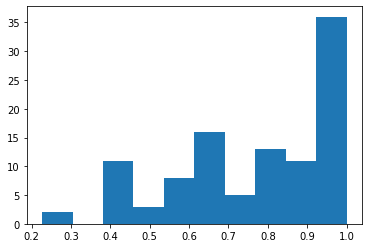

In [19]:
plt.hist(sim, bins = 10)
plt.show()

In [20]:
data["sim_bert"] = sim
data.head()

,id,text_1,text_2,sim,A_2,B_2,match2,sim_bert
0,30,the following management 's discussion and ana...,the following tables contain selected statemen...,0.137545,1,1,1,0.581401
1,98,the preparation of consolidated financial stat...,the preparation of consolidated financial stat...,1.000000,1,1,1,1.000000
2,13,"we have historically developed , marketed and ...","on february dd , we entered into an asset purc...",0.335990,0,0,1,0.585143
3,7,"( b ) the "" cosmetic "" segment of our busine...","( b ) during the year ended december dd , dd...",0.384477,1,1,1,0.556532
4,62,revenues for the company 's first ge...,"during fiscal dd , the company 's to...",0.619997,1,1,1,0.913838


In [24]:
data["sim_bert_bin"] = data["sim_bert"].round(decimals=1)
data["same_topic"] = data["A_2"]*data["B_2"]
data.groupby("sim_bert_bin")["same_topic"].mean()
data.groupby("sim_bert_bin")["same_topic"].size()

sim_bert_bin
0.2    0.000000
0.4    0.000000
0.5    0.000000
0.6    0.545455
0.7    0.555556
0.8    1.000000
0.9    1.000000
1.0    1.000000
Name: same_topic, dtype: float64

sim_bert_bin
0.2     2
0.4    10
0.5     4
0.6    11
0.7    18
0.8    13
0.9    14
1.0    33
Name: same_topic, dtype: int64

In [36]:
len(data[data["sim_bert"]>0.7])
data[data["sim_bert"]>0.7].same_topic.sum()

64

63

In [37]:
63/64

0.984375